In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))
import pyomo.environ as pyo

import pvlib
import math
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import time
import pypsa
import sys
from pyomo.environ import *

In [2]:
import pandas
print(pandas.__version__)

1.1.3


### MINLP - смешанно-целочисленное нелинейное программирование

<b><center> Целевая функция: </center></b>

$$min \ OPEX = \sum_{t=1}^{48} \sum_{i=1}^{4} \sum_{j=1}^{7} \sum_{k=1}^{2} \sum_{m=1}^{2} F\cdot (0.0219\cdot P_{max}^{DGU1}\cdot u_t^{DGU1}+0.3125\cdot P_t^{DGU1} 
+ 0.0219\cdot P_{max}^{DGU2}\cdot u_t^{DGU2}+0.3125\cdot P_t^{DGU2} + 0.049\cdot P_{max}^{DGU3}\cdot u_t^{DGU3}+0.2788\cdot P_t^{DGU3}+
0.049\cdot P_{max}^{DGU4}\cdot u_t^{DGU4}+0.2788\cdot P_t^{DGU4}) + SU_{i,t}^{DGU} + SD_{i,t}^{DGU} + PV_{j,t}^{cost} + ESS_{k,t}^{cost} + ESS_{m,t}^{cost} $$

где $F$ - цена за 1 литр дизтоплива, руб (принято за 45 руб.); $P_{max}^{DGU1}$ - максимальная активная мощность дизель-генератора №1, кВт  ; $P_t^{DGU1}$ - мощность дизель-генератора №1 в момент времени $t$, кВт; $u_t^{DGU1}$ - бинарный коэффициент состояния дизель-генератора №1 в момент времени $t$ (0 - выкл; 1 - вкл); $SU_{i,t}^{DGU}$ - затраты на пуск $i$-го дизель-генератора в момент времени $t$; $SD_{i,t}^{DGU}$ - затраты на останов $i$-го дизель-генератора в момент времени $t$; $PV_{j,t}^{cost}$ - эксплуатационные затраты $j$-го инвертора в момент времени $t$; $ESS_{k,t}^{cost}$ - эксплуатационные затраты $k$-го инвертора СНЭ в момент времени $t$; ESS_{m,t}^{cost} - эксплуатационные затраты $m$-й СНЭ в момент времени $t$ $$

<b><center> Ограничения: </center></b>

$t\in\mathcal{T}$ - множество временных периодов (ч); \
$i\in\mathcal{I}$ - множество дизель-генераторов; \
$j\in\mathcal{J}$ - множество инверторов СЭС; \
$k\in\mathcal{K}$ - множество инверторов/массивов СНЭ; \
$l\in\mathcal{L}$ - множество потребителей ЭЭ;

<center> 1. Глобальные ограничения: </center>

<p><center> 1) Баланс мощности:  </center></p>

$$\sum_{i\in\mathcal{I}}P_{i,t}^{DGU}+\widehat{\sum_{j\in\mathcal{J}}P_{j,t}^{PV}}-\sum_{k\in\mathcal{K}}P_{k,t}^{charge}
+\sum_{k\in\mathcal{K}}P_{k,t}^{discharge}= \widehat{\sum_{l\in\mathcal{L}}P_{l,t}^{load}} \qquad \forall t \in \mathcal{T}$$

<p><center> где $\widehat {P_{l,t}^{load}} = \widehat{P_{t}^{consumer}}+\widehat{P_{t}^{self}}$ - прогнозная суммарная активная нагрузка (потребитель + собственные нужды), кВт </center></p>

<p><center> 2. Ограничения на работу ДГУ: </center></p>

<p><center> 1) Удельная загрузка $i$-го работающего дизель-генератора в момент времени $t$ больше или равна 0.5: </center></p>

$$\begin{cases}u_{i,t} = 1,\\\frac{P_{i,t}}{P_{i}^{max}} \geq 0.5\end{cases} \hspace{.5cm} \forall i \in \mathcal{I}, \ t \in \mathcal{T}$$ 

<p><center> 2) Готовность к работе $i$-го дизель-генератора в течение всего расчетного периода $\mathcal{T}$:  </center></p>

$$ a_{i}^{DGU}\cdot u_{i,t} - u_{i,t} = 0 \hspace{.5cm} \forall i \in \mathcal{I}, \ t \in \mathcal{T}, a \in [0,1]$$

<p><center> где $a_{i}$ - бинарный коэффициент доступности $i$-го дизель-генератора на весь расчетный период $\mathcal{T}$ (1 - доступен, 0 - ремонт, тех.обслуживание, авария и т.д.) </center></p>


<p><center> 3) Минимальное число последовательных часов ДГУ в работе (пока принято за 3 часа):  </center></p>

$$[h_i^{up}(t-1)-T_i^{up}][u_i(t-1)-u_i(t)]\geq0 \qquad \forall t \in \mathcal{T}$$

<p><center>где $h_i^{up}(t-1)$ - число последовательных часов к концу $(t-1)$-го часа, в течение которых $i$-ый дизель-генератор был в работе;  $T_i^{up}$ - минимальное допустимое число последовательных часов $i$-го дизель-генератора в работе; $u_i(t)$ - бинарный коэффициент состояния $i$-го дизель-генератора в момент времени $t$ (0 - выкл; 1 - вкл) </center></p>

<p><center> 4) Минимальное число последовательных часов простоя ДГУ (пока принято за 3 часа):  </center></p>

$$[h_i^{down}(t-1)+T_i^{down}][u_i(t)-u_i(t-1)]\leq0 \qquad \forall t \in \mathcal{T}$$

<p><center>где $h_i^{down}(t-1)$ - число последовательных часов к концу $(t-1)$-го часа, в течение которых $i$-ый дизель-генератор простаивал;  $T_i^{down}$ - минимальное допустимое число последовательных часов простоя $i$-го дизель-генератора </center></p>

<p><center> 5) Затраты на пуск $i$-го дизель-генератора в момент времени $t$:  </center></p>

$$SU_{i,t}^{DGU} \geq SU_{i}^{DGU} (u_{i,t} - u_{i,t-1})   \hspace{.5cm} \forall i \in \mathcal{I}, \ t \in \mathcal{T} $$

<p><center> где $SU_{i}^{DGU}$ - затраты на пуск $i$-го дизель-генератора, руб </center></p>

<p><center> 6) Затраты на останов $i$-го дизель-генератора в момент времени $t$:  </center></p>

$$SD_{i,t}^{DGU} \geq SD_{i}^{DGU} (u_{i,t-1} - u_{i,t})   \hspace{.5cm} \forall i \in \mathcal{I}, \ t \in \mathcal{T} $$

<p><center> где $SD_{i}^{DGU}$ - затраты на останов $i$-го дизель-генератора, руб </center></p>

<p><center> 2. Ограничения на работу СНЭ: </center></p>

<p><center> 1) Поддержание уровня заряда СНЭ в установленных пределах: </center></p>

$$(1-DOD_{k,min})\leq\eta_k^s SOC_{k, t-1}+100 \cdot \left(P_{k,t}^{charge} \cdot \eta_k^{charge} + \frac {P_{k,t}^{discharge}}{\eta_k^{discharge}}\right) \frac{\Delta t}{C_k}\leq SOC_{k,max} \hspace{.5cm} \forall k \in \mathcal{K}, \ t \in \mathcal{T} $$

<p><center> где $\eta_k^s$ - коэффициент саморазряда $k$-й СНЭ, %; $C_k$ - емкость $k$-й СНЭ, кВтч; $DOD_{k,min}$ - максимальная глубина разряда (70%), %; $SOC_{k}$ - уровень заряда $k$-й СНЭ  </center></p>

<p><center> 2) Ограничение допустимой скорости (мощности) разряда/заряда $k$-й СНЭ: </center></p>

$$P_{k,t}^{dch} \leq P_{k,max}^{dch} \hspace{.5cm} \forall k \in \mathcal{K}, \ t \in \mathcal{T} $$   
$$P_{k,t}^{ch} \leq P_{k,max}^{ch} \hspace{.5cm} \forall k \in \mathcal{K}, \ t \in \mathcal{T} $$

<p><center> 3) Ограничение одновременного разряда и заряда $k$-й СНЭ в момент времени $t$: </center></p>

$$P_{k,t}^{dch} \cdot P_{k,t}^{ch} = 0\hspace{.5cm} \forall k \in \mathcal{K}, \ t \in \mathcal{T} $$

<p><center> 4) Готовность к работе $k$-й СНЭ в течение всего расчетного периода $\mathcal{T}$: </center></p>

$$ a_{k}^{ESS}\cdot P_{k,t}^{ch/dch} - P_{k,t}^{ch/dch} = 0 \hspace{.5cm} \forall k \in \mathcal{K}, \ t \in \mathcal{T}, a \in [0,1]$$

<p><center> 3. Ограничения на работу СЭС: </center></p>

<p><center> 1) Ограничение мощности $j$-го инвертора СЭС в момент времени $t$ не должно превышать доступную мощность заряда $k$-й СНЭ:  </center></p>

$$ P_{j,t}^{PV} - \widehat{P_{j,t}^{PV_{max}}} - \frac{P_{k,t}^{ch}}{{P_{k,t}^{ch_{max}}}} \leq 0 \hspace{.5cm} \forall j \in \mathcal{J}, \ k \in \mathcal{K}, \ t \in \mathcal{T}$$

<p><center> где $\widehat{P_{j,t}^{PV_{max}}}$ - прогнозная максимальная доступная выходная мощность $j$-го инвертора СЭС, кВт; 
</center></p>

<p><center> 2) Готовность к работе $j$-го инвертора СЭС в течение всего расчетного периода $\mathcal{T}$: </center></p>

$$ a_{j}^{PV}\cdot P_{j,t}^{PV} - P_{j,t}^{PV} = 0 \hspace{.5cm} \forall j \in \mathcal{J}, \ t \in \mathcal{T}, a \in [0,1]$$

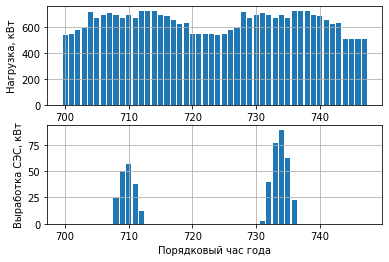

In [132]:
location = pvlib.location.Location(67.5538, 133.38976, tz='Asia/Vladivostok', altitude=137, name='Verkhoyansk')

Load0 = pd.read_csv('Load.csv', sep=';')
Load = Load0.Load
#Load.to_excel('Demand.xls')

poa=pd.read_csv('verkhoyansk_era5.csv') #index_col=0, #parse_dates=True) #poa_irr.csv

poa_global = poa['Верхоянск.14'][9:]
poa_global = poa_global.astype('float')
poa_global = poa_global.reset_index()
PV = 1.3*poa_global['Верхоянск.14']*0.2*5200/1000

# demand
T1 = 700 #1700, 3700, 3865, 1875, 3605
T2 = 748 #1724, 3724, 3915, 1920, 3650

T = np.array([t for t in range(T1, T2)])

fig, ax = plt.subplots(2,1)
ax[0].bar(Load[T].index, Load[T])
ax[0].set_xlabel('Порядковый час года')
ax[0].set_ylabel('Нагрузка, кВт')
ax[1].bar(PV[T].index, PV[T])
ax[1].set_xlabel('Порядковый час года')
ax[1].set_ylabel('Выработка СЭС, кВт')
plt.show()
fig.tight_layout(pad=5)

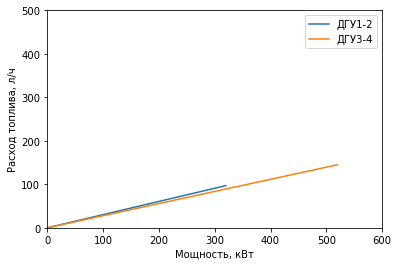

In [129]:
# generating units
N = 4
N = np.array([n for n in range(0, N)])


p12 = np.arange(0, 321)
p34 = np.arange(0, 521)
p_PV = np.arange(0, 137)
p_BESS = np.arange(0, 151)


DGU1_pmax = 320 #кВт
DGU1_pmin = 0.5*DGU1_pmax

DGU2_pmax = 320 #кВт
DGU2_pmin = 0.5*DGU2_pmax

DGU3_pmax = 520 #кВт
DGU3_pmin = 0.5*DGU3_pmax

DGU4_pmax = 520 #кВт
DGU4_pmin = 0.5*DGU4_pmax

DGU1_fuel =  0.3031*p12
DGU2_fuel =  0.3031*p12
DGU3_fuel = 0.2788*p34
DGU4_fuel = 0.2788*p34

d12_startup_cost = 1000
d34_startup_cost = 2000

d12_shutdown_cost = 1100
d34_shutdown_cost = 2100

Fuel_price = 60 #цена за литр диз.топлива 

ESS_inv = 150

fig, ax = plt.subplots(1,1)

ax.plot(DGU1_fuel, label='ДГУ1-2')
ax.plot(DGU3_fuel, label='ДГУ3-4')

ax.set_xlim(0, 600)
ax.set_ylim(0, 500)
ax.set_xlabel('Мощность, кВт')
ax.set_ylabel('Расход топлива, л/ч')
ax.legend(loc='best')
ax.grid()

In [134]:
m = pyo.ConcreteModel()

output = []

#Граничные условия

d1_up_before = 0
d2_up_before = 0
d3_up_before = 2
d4_up_before = 0

d1_down_before = 3
d2_down_before = 3
d3_down_before = 1
d4_down_before = 3

u1_start = 0
u2_start = 0
u3_start = 1
u4_start = 0

d1_availability_state = 1
d2_availability_state = 1
d3_availability_state = 1
d4_availability_state = 1

d1_min_up_time = 3
d2_min_up_time = 3 
d3_min_up_time = 3 
d4_min_up_time = 3

d1_min_down_time = 3
d2_min_down_time = 3 
d3_min_down_time = 3 
d4_min_down_time = 3 

ess1_availability_state = 1
ess2_availability_state = 1

soc1_before = 100
soc2_before = 100

soc1_after = 80
soc2_after = 80

#Ограничения
def balance(model, i):
    return m.x1[i] + m.x2[i] + m.x3[i] + m.x4[i] + m.bat1_dch[i] - m.bat1_ch[i] + m.bat2_dch[i] - m.bat2_ch[i] + m.PV1[i] + m.PV2[i] + m.PV3[i] + m.PV4[i] + m.PV5[i] + m.PV6[i] + m.PV7[i] == (np.asarray(Load)[i]) # +  

def d1_start_up_cost(model, i):
    if i == T1:
        return m.suc1[i] >= d12_startup_cost*(m.u1[i]-u1_start)
    else:
        return m.suc1[i] >= d12_startup_cost*(m.u1[i]-m.u1[i-1])
    
def d2_start_up_cost(model, i):
    if i == T1:
        return m.suc2[i] >= d12_startup_cost*(m.u2[i]-u2_start)
    else:
        return m.suc2[i] >= d12_startup_cost*(m.u2[i]-m.u2[i-1])
    
def d3_start_up_cost(model, i):
    if i == T1:
        return m.suc3[i] >= d34_startup_cost*(m.u3[i]-u3_start)
    else:
        return m.suc3[i] >= d34_startup_cost*(m.u3[i]-m.u3[i-1])
    
def d4_start_up_cost(model, i):
    if i == T1:
        return m.suc4[i] >= d34_startup_cost*(m.u4[i]-u4_start)
    else:
        return m.suc4[i] >= d34_startup_cost*(m.u4[i]-m.u4[i-1])
    
def d1_shut_down_cost(model, i):
    if i == T1:
        return m.sdc1[i] >= d12_shutdown_cost*(u1_start-m.u1[i])
    else:
        return m.sdc1[i] >= d12_shutdown_cost*(m.u1[i-1]-m.u1[i])

def d2_shut_down_cost(model, i):
    if i == T1:
        return m.sdc2[i] >= d12_shutdown_cost*(u2_start-m.u2[i])
    else:
        return m.sdc2[i] >= d12_shutdown_cost*(m.u2[i-1]-m.u2[i])
    
def d3_shut_down_cost(model, i):
    if i == T1:
        return m.sdc3[i] >= d34_shutdown_cost*(u3_start-m.u3[i])
    else:
        return m.sdc3[i] >= d34_shutdown_cost*(m.u3[i-1]-m.u3[i])

def d4_shut_down_cost(model, i):
    if i == T1:
        return m.sdc4[i] >= d34_shutdown_cost*(u4_start-m.u4[i])
    else:
        return m.sdc4[i] >= d34_shutdown_cost*(m.u4[i-1]-m.u4[i])


# def d1o(model, i):
#     if i == T1:
#         return m.u1[i] - d1_min_up_time*(m.u1[i] - u1_start) >= 0
#     else:

#         return sum(uj) >= d1_min_up_time*(m.u1[i] - m.u1[i-1])


# def d2o(model, i):
#     if i == T1:
#         return (1-m.u3[i]) >= d3_min_down_time*(u3_start - m.u3[i])
#     if i > T2-3:
#         return m.u3[i+1] + m.u3[i+2] + m.u3[i+3]  >= d1_min_down_time*(m.u1[i-1] - m.u1[i])

# def d1_partial(model, i):
#     return m.x1

def d1_min_up_time_c(model, i):
    if i == T1:
        return (d1_up_before - d1_min_up_time)*(u1_start - m.u1[i]) >= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u1[i-1])
        for j in range(T1, i):
            uj.append(m.u1[j])
        return ((sum(uj) - d1_min_up_time)*(m.u1[i-1] - m.u1[i])) >= 0
    else:
        return ((m.u1[i-1] + m.u1[i-2] + m.u1[i-3] - d1_min_up_time)*(m.u1[i-1] - m.u1[i])) >= 0
    
def d2_min_up_time_c(model, i):
    if i == T1:
        return (d2_up_before - d2_min_up_time)*(u2_start - m.u2[i]) >= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u2[i-1])
        for j in range(T1, i):
            uj.append(m.u2[j])
        return ((sum(uj) - d2_min_up_time)*(m.u2[i-1] - m.u2[i])) >= 0
    else:
        return ((m.u2[i-1] + m.u2[i-2] + m.u2[i-3] - d2_min_up_time)*(m.u2[i-1] - m.u2[i])) >= 0
    
def d3_min_up_time_c(model, i):
    if i == T1:
        return (d3_up_before - d3_min_up_time)*(u3_start - m.u3[i]) >= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u3[i-1])
        for j in range(T1, i):
            uj.append(m.u3[j])
        return ((sum(uj) - d3_min_up_time)*(m.u3[i-1] - m.u3[i])) >= 0
    else:
        return ((m.u3[i-1] + m.u3[i-2] + m.u3[i-3] - d3_min_up_time)*(m.u3[i-1] - m.u3[i])) >= 0

def d4_min_up_time_c(model, i):
    if i == T1:
        return (d4_up_before - d4_min_up_time)*(u4_start - m.u4[i]) >= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u4[i-1])
        for j in range(T1, i):
            uj.append(m.u4[j])
        return ((sum(uj) - d4_min_up_time)*(m.u4[i-1] - m.u4[i])) >= 0
    else:
        return ((m.u4[i-1] + m.u4[i-2] + m.u4[i-3] - d4_min_up_time)*(m.u4[i-1] - m.u4[i])) >= 0

def d1_min_down_time_c(model, i):
    if i == T1:
        return (d1_down_before + d1_min_down_time)*(-u1_start + m.u1[i]) <= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u1[i-1])
        for j in range(T1, i):
            uj.append(m.u1[j])
        return ((sum(uj) - 2 + d1_min_down_time)*(-m.u1[i-1] + m.u1[i])) <= 0
    else:
        return ((m.u1[i-1] + m.u1[i-2] + m.u1[i-3] - 3 + d1_min_down_time)*(-m.u1[i-1] + m.u1[i])) <= 0

def d2_min_down_time_c(model, i):
    if i == T1:
        return (d2_down_before + d2_min_down_time)*(-u2_start + m.u2[i]) <= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u2[i-1])
        for j in range(T1, i):
            uj.append(m.u2[j])
        return ((sum(uj) - 2 + d2_min_down_time)*(-m.u2[i-1] + m.u2[i])) <= 0
    else:
        return ((m.u2[i-1] + m.u2[i-2] + m.u2[i-3] - 3 + d2_min_down_time)*(-m.u2[i-1] + m.u2[i])) <= 0

def d3_min_down_time_c(model, i):
    if i == T1:
        return (d3_down_before + d3_min_down_time)*(-u3_start + m.u3[i]) <= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u3[i-1])
        for j in range(T1, i):
            uj.append(m.u3[j])
        return ((sum(uj) - 2 + d3_min_down_time)*(-m.u3[i-1] + m.u3[i])) <= 0
    else:
        return ((m.u3[i-1] + m.u3[i-2] + m.u3[i-3] - 3 + d3_min_down_time)*(-m.u3[i-1] + m.u3[i])) <= 0

def d4_min_down_time_c(model, i):
    if i == T1:
        return (d4_down_before + d4_min_down_time)*(-u4_start + m.u4[i]) <= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u4[i-1])
        for j in range(T1, i):
            uj.append(m.u4[j])
        return ((sum(uj) - 2 + d4_min_down_time)*(-m.u4[i-1] + m.u4[i])) <= 0
    else:
        return ((m.u4[i-1] + m.u4[i-2] + m.u4[i-3] - 3 + d4_min_down_time)*(-m.u4[i-1] + m.u4[i])) <= 0

#ограничение глубины разряда СНЭ  
def soc1_ctrl(model, i):
    if i == T1:
        return m.soc1[i] == soc1_before - 100*m.bat1_dch[i]/700 + 100*m.bat1_ch[i]/700
    else:
        return m.soc1[i] == m.soc1[i-1] - 100*m.bat1_dch[i]/700 + 100*m.bat1_ch[i]/700

def soc2_ctrl(model, i):
    if i == T1:
        return m.soc2[i] == soc2_before - 100*m.bat2_dch[i]/700 + 100*m.bat2_ch[i]/700
    else:
        return m.soc2[i] == m.soc2[i-1] - 100*m.bat2_dch[i]/700 + 100*m.bat2_ch[i]/700
    
#СНЭ не должна заряжаться и разряжаться одновременно     
def ch_x_dch1 (model, i):
    return m.bat1_ch[i] * m.bat1_dch[i] == 0

def ch_x_dch2 (model, i):
    return m.bat2_ch[i] * m.bat2_dch[i] == 0

def ess12(model, i):
    return m.bat1_dch[i] - m.bat2_ch[i] - m.bat1_dch[i] == 0 #m.bat1_dch[i] - m.bat2_ch[i] - m.bat1_dch[i] <= 0 

def ess21(model, i):
    return m.bat2_dch[i] - m.bat1_ch[i] - m.bat2_dch[i] == 0 

#если СНЭ заряжена не на 100%, не ограничиваем инверторы СЭС 
def curtailment_control1 (model, i):
    return m.PV1[i]+ m.PV2[i]+m.PV3[i]+m.PV4[i]+m.PV5[i]+m.PV6[i]+m.PV7[i] - PV[i] - m.bat1_ch[i]/ESS_inv  <= 0 

def curtailment_control2 (model, i):
    return m.PV1[i]+ m.PV2[i]+m.PV3[i]+m.PV4[i]+m.PV5[i]+m.PV6[i]+m.PV7[i] - PV[i] - m.bat2_ch[i]/ESS_inv  <= 0 

def d1_availability (model, i):
    return m.u1[i] == m.u1[i] * d1_availability_state

def d2_availability (model, i):
    return m.u2[i] == m.u2[i] * d2_availability_state

def d3_availability (model, i):
    return m.u3[i] == m.u3[i] * d3_availability_state

def d4_availability (model, i):
    return m.u4[i] == m.u4[i] * d4_availability_state


def ess1_availability (model, i):
    return m.bat1_dch[i] + m.bat1_ch[i] == (m.bat1_dch[i] + m.bat1_ch[i]) * ess1_availability_state

def ess2_availability (model, i):
    return m.bat2_dch[i] + m.bat2_ch[i] == (m.bat2_dch[i] + m.bat2_ch[i]) * ess2_availability_state

def cycle1(model, i):
    return m.soc1[T1+T2-T1-1] >= soc1_after

def cycle2(model, i):
    return m.soc2[T1+T2-T1-1] >= soc2_after

def as_one1(model, i):
    return m.bat1_dch[i] == m.bat2_dch[i] 

def as_one2(model, i):
    return m.bat1_ch[i] == m.bat2_ch[i] 

def unit_commitment():
    
    m.N = pyo.Set(initialize=N)
    m.T = pyo.Set(initialize=T)

    m.x1 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, DGU1_pmax))
    m.u1 = pyo.Var(m.T, domain=pyo.Binary)
    
    m.x2 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, DGU2_pmax))
    m.u2 = pyo.Var(m.T, domain=pyo.Binary)
    
    m.x3 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, DGU3_pmax))
    m.u3 = pyo.Var(m.T, domain=pyo.Binary)
    
    m.x4 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, DGU4_pmax))
    m.u4 = pyo.Var(m.T, domain=pyo.Binary)
    
    m.bat1_dch = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, ESS_inv))
    m.bat1_ch = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, ESS_inv))
    
    m.bat2_dch = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, ESS_inv))
    m.bat2_ch = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, ESS_inv))
    
    m.soc1 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (50, 100))
    m.soc2 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (50, 100))
    
    m.suc1 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, d12_startup_cost))
    m.suc2 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, d12_startup_cost))
    m.suc3 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, d34_startup_cost))
    m.suc4 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, d34_startup_cost))
    
    m.sdc1 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, d12_shutdown_cost))
    m.sdc2 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, d12_shutdown_cost))
    m.sdc3 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, d34_shutdown_cost))
    m.sdc4 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, d34_shutdown_cost))
    
    m.PV1 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV2 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV3 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV4 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV5 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV6 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV7 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    
    #m.PV1_s = pyo.Var(m.T, domain=pyo.Binary)
    #m.PV2_s = pyo.Var(m.T, domain=pyo.Binary)
    
    
    # целевая функция
    m.cost = pyo.Objective(expr = sum(Fuel_price*((0.0219*DGU1_pmax*m.u1[t] + 0.3125*m.x1[t]) + (0.0219*DGU2_pmax*m.u2[t] + 0.3125*m.x2[t]) +
                                      (0.049*DGU3_pmax*m.u3[t] + 0.2788*m.x3[t]) + (0.049*DGU4_pmax*m.u4[t] + 0.2788*m.x4[t])) + m.suc1[t] +
                                      m.suc2[t] + m.suc3[t] + m.suc4[t] + m.sdc1[t] +
                                      m.sdc2[t] + m.sdc3[t] + m.sdc4[t] +
                                      27432*0.000033*(m.bat1_ch[t]+m.bat1_dch[t]) + 27432*0.000033*(m.bat2_ch[t]+m.bat2_dch[t]) +
                                      m.u1[t]*100 + m.u2[t]*100 + m.u3[t]*100 + m.u4[t]*100
                                      for t in m.T), sense=pyo.minimize)
    
    
    m.demand = pyo.Constraint(m.T, rule=balance)
    
    
    m.lb1 = pyo.Constraint(m.T, rule=lambda m, t: DGU1_pmin*m.u1[t] <= m.x1[t])
    m.ub1 = pyo.Constraint(m.T, rule=lambda m, t: DGU1_pmax*m.u1[t] >= m.x1[t])
    m.lb2 = pyo.Constraint(m.T, rule=lambda m, t: DGU2_pmin*m.u2[t] <= m.x2[t])
    m.ub2 = pyo.Constraint(m.T, rule=lambda m, t: DGU2_pmax*m.u2[t] >= m.x2[t])
    m.lb3 = pyo.Constraint(m.T, rule=lambda m, t: DGU3_pmin*m.u3[t] <= m.x3[t])
    m.ub3 = pyo.Constraint(m.T, rule=lambda m, t: DGU3_pmax*m.u3[t] >= m.x3[t])
    m.lb4 = pyo.Constraint(m.T, rule=lambda m, t: DGU4_pmin*m.u4[t] <= m.x4[t])
    m.ub4 = pyo.Constraint(m.T, rule=lambda m, t: DGU4_pmax*m.u4[t] >= m.x4[t])
    
    m.pv1 = pyo.Constraint(m.T, rule=lambda m, t: m.PV1[t] <= PV[t]/7)
    m.pv2 = pyo.Constraint(m.T, rule=lambda m, t: m.PV2[t] <= PV[t]/7)
    m.pv3 = pyo.Constraint(m.T, rule=lambda m, t: m.PV3[t] <= PV[t]/7)
    m.pv4 = pyo.Constraint(m.T, rule=lambda m, t: m.PV4[t] <= PV[t]/7)
    m.pv5 = pyo.Constraint(m.T, rule=lambda m, t: m.PV5[t] <= PV[t]/7)
    m.pv6 = pyo.Constraint(m.T, rule=lambda m, t: m.PV6[t] <= PV[t]/7)
    m.pv7 = pyo.Constraint(m.T, rule=lambda m, t: m.PV7[t] <= PV[t]/7)
    
    m.pv1_curtailment = pyo.Constraint(m.T, rule=curtailment_control1)
    m.pv2_curtailment = pyo.Constraint(m.T, rule=curtailment_control2)
    
    m.min_up_time_d1 = pyo.Constraint(m.T, rule=d1_min_up_time_c)
    m.min_up_time_d2 = pyo.Constraint(m.T, rule=d2_min_up_time_c)
    m.min_up_time_d3 = pyo.Constraint(m.T, rule=d3_min_up_time_c)
    m.min_up_time_d4 = pyo.Constraint(m.T, rule=d4_min_up_time_c)
    
    m.min_down_time_d1 = pyo.Constraint(m.T, rule=d1_min_down_time_c)
    m.min_down_time_d2 = pyo.Constraint(m.T, rule=d2_min_down_time_c)
    m.min_down_time_d3 = pyo.Constraint(m.T, rule=d3_min_down_time_c)
    m.min_down_time_d4 = pyo.Constraint(m.T, rule=d4_min_down_time_c)
    
    m.su1 = pyo.Constraint(m.T, rule=d1_start_up_cost)
    m.su2 = pyo.Constraint(m.T, rule=d2_start_up_cost)
    m.su3 = pyo.Constraint(m.T, rule=d3_start_up_cost)
    m.su4 = pyo.Constraint(m.T, rule=d4_start_up_cost)
    
    m.sd1 = pyo.Constraint(m.T, rule=d1_shut_down_cost)
    m.sd2 = pyo.Constraint(m.T, rule=d2_shut_down_cost)
    m.sd3 = pyo.Constraint(m.T, rule=d3_shut_down_cost)
    m.sd4 = pyo.Constraint(m.T, rule=d4_shut_down_cost)
    
    m.d1_ava = pyo.Constraint(m.T, rule=d1_availability)
    m.d2_ava = pyo.Constraint(m.T, rule=d2_availability)
    m.d3_ava = pyo.Constraint(m.T, rule=d3_availability)
    m.d4_ava = pyo.Constraint(m.T, rule=d4_availability)
    
    m.soc1_ctrl = pyo.Constraint(m.T, rule=soc1_ctrl)
    m.soc2_ctrl = pyo.Constraint(m.T, rule=soc2_ctrl)
    m.chdch1 = pyo.Constraint(m.T, rule=ch_x_dch1)
    m.chdch2 = pyo.Constraint(m.T, rule=ch_x_dch2)
    #m.ess12 = pyo.Constraint(m.T, rule=ess12)
    #m.ess21 = pyo.Constraint(m.T, rule=ess21)
    m.ess1_ava = pyo.Constraint(m.T, rule=ess1_availability)
    m.ess2_ava = pyo.Constraint(m.T, rule=ess2_availability)
    #m.d1_cstr1 = pyo.Constraint(m.T, rule=d1_cstr1)
    #m.curt1 = pyo.Constraint(m.T, rule=curtailment_control1) 
    #m.ess1_cyc = pyo.Constraint(m.T, rule=cycle1)
    #m.ess2_cyc = pyo.Constraint(m.T, rule=cycle2)
    
    m.as_one1 = pyo.Constraint(m.T, rule=as_one1)
    m.as_one2 = pyo.Constraint(m.T, rule=as_one2)
    
    return m

m = unit_commitment()


# Create a model instance and optimize
#instance = m.create_instance("d.dat")

opt =  pyo.SolverFactory('scipampl')
#opt.options["parallel/mode"] = 1
#opt.options['numthreads'] = 8
#opt.options['parallel/maxnthreads'] = 4
#opt.options['limits/gap'] = 0.05


results = opt.solve(m, logfile=r'C:\Users\Narynbaev\Documents\Оптимизация Верхоянск\couenne_logg.log', tee=True, timelimit=6000, keepfiles=True)
results.write()
#pyo.SolverFactory('mindtpy').solve(m, mip_solver='cbc', nlp_solver='ipopt', tee=True).write()



# Extract model output in list
Date = list(Load[T].index)
output.append([Date, m.x1.get_values().values(), m.x2.get_values().values(), 
                m.x3.get_values().values(), m.x4.get_values().values(), m.bat1_dch.get_values().values(),
              m.bat1_ch.get_values().values()]) 
                #m.bat1_dch.get_values().values(), m.bat1_ch.get_values().values(), ])


dfout = pd.DataFrame()
#dfout.index=Load[T].index
dfout['Load'] = Load[T1:T2]
dfout['d1'] = m.x1.get_values().values()
dfout['d2'] = m.x2.get_values().values()
dfout['d3'] = m.x3.get_values().values()
dfout['d4'] = m.x4.get_values().values()
# dfout['d1_suc'] = m.suc1.get_values().values()
# dfout['d2_suc'] = m.suc2.get_values().values()
# dfout['d3_suc'] = m.suc3.get_values().values()
# dfout['d4_suc'] = m.suc4.get_values().values()
# dfout['d1_sdc'] = m.sdc1.get_values().values()
# dfout['d2_sdc'] = m.sdc2.get_values().values()
# dfout['d3_sdc'] = m.sdc3.get_values().values()
# dfout['d4_sdc'] = m.sdc4.get_values().values()
dfout['bat1_dch'] = m.bat1_dch.get_values().values()
dfout['bat1_ch'] = m.bat1_ch.get_values().values()
dfout['bat2_dch'] = m.bat2_dch.get_values().values()
dfout['bat2_ch'] = m.bat2_ch.get_values().values()
dfout['soc1'] = m.soc1.get_values().values()
dfout['soc2'] = m.soc2.get_values().values()
dfout['pv1'] = m.PV1.get_values().values()
dfout['pv2'] = m.PV2.get_values().values()
dfout['pv3'] = m.PV3.get_values().values()
dfout['pv4'] = m.PV4.get_values().values()
dfout['pv5'] = m.PV5.get_values().values()
dfout['pv6'] = m.PV6.get_values().values()
dfout['pv7'] = m.PV7.get_values().values()
dfout['bat1_ch'] = -dfout['bat1_ch']
dfout['bat2_ch'] = -dfout['bat2_ch']
#dfout['dd1'] = m.u1.get_values().values()

dfout.index = Load[T1:T2].index
dfout['Load'] = Load[T1:T2]


Solver log file: 'C:\Users\Narynbaev\Documents\Оптимизация Верхоянск\couenne_logg.log'
Solver solution file: 'C:\Users\NARYNB~1\AppData\Local\Temp\tmpn0mx4i4j.pyomo.sol'
Solver problem files: ('C:\\Users\\NARYNB~1\\AppData\\Local\\Temp\\tmpn0mx4i4j.pyomo.nl',)
SCIP version 7.0.0 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.0] [GitHash: 0bc4dc9c65]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.0         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 6535a3c8]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  bliss 0.73p          Computing Graph Automorphism Groups by T. Junttila and P. Kaski (http://www.tcs.hut.fi/Software/bliss/)
  Ipopt 3.13.1         Interior Point Optimizer developed by A. Waechter et.al. (www.coin-or.org/Ipopt)
  ASL                  AMPL Solver Library developed 

d14.0s|    40 |    41 |  8783 | 175.4 |pscostdi|  24 |1464 |1897 |1655 |   0 |  1 | 102 | 602 | 5.959358e+05 | 6.062570e+05 |   1.73%| unknown
d15.0s|    62 |    58 | 10788 | 145.0 |adaptive|  24 |1464 |1897 |1618 |   0 |  1 | 102 | 630 | 5.961027e+05 | 6.041181e+05 |   1.34%| unknown
 15.0s|   100 |    92 | 13320 | 114.9 |    40M |  26 |1464 |1907 |1570 |1107 |  2 | 112 | 639 | 5.961027e+05 | 6.041181e+05 |   1.34%| unknown
L15.0s|   110 |   102 | 13714 | 108.0 |    alns|  26 |1464 |1907 |1638 |1178 |  2 | 112 | 639 | 5.961027e+05 | 6.040379e+05 |   1.33%| unknown
L16.0s|   139 |   131 | 27106 | 182.4 |    alns|  26 |1464 |1910 |1621 |1437 |  2 | 115 | 647 | 5.961027e+05 | 6.027247e+05 |   1.11%| unknown
*17.0s|   192 |   164 | 29525 | 144.4 |    LP  |  29 |1464 |1910 |1651 |1647 |  2 | 117 | 660 | 5.961027e+05 | 6.026307e+05 |   1.10%| unknown
 17.0s|   200 |   170 | 29689 | 139.4 |    42M |  33 |1464 |1910 |1665 |1661 |  1 | 117 | 661 | 5.961027e+05 | 6.026307e+05 |   1.10%| unknown

In [75]:
m.u1.get_values().values()

d1_up_before = sum(list(m.u1.get_values().values())[21:])
d2_up_before = sum(list(m.u2.get_values().values())[21:])
d3_up_before = sum(list(m.u3.get_values().values())[21:])
d4_up_before = sum(list(m.u4.get_values().values())[21:])

d1_down_before = 4 - d1_up_before
d2_down_before = 4 - d2_up_before
d3_down_before = 4 - d3_up_before
d4_down_before = 4 - d4_up_before

u1_start = list(m.u1.get_values().values())[23]
u2_start = list(m.u2.get_values().values())[23]
u3_start = list(m.u3.get_values().values())[23]
u4_start = list(m.u4.get_values().values())[23]

soc1_before = list(m.soc1.get_values().values())[23]
soc2_before = list(m.soc2.get_values().values())[23]

soc1_after = 80
soc2_after = 80

In [80]:
list(m.soc2.get_values().values())[23]

50.0

In [109]:
output = []
T1=700
T2=748
T = np.array([t for t in range(T1, T2)])
d1_up_before = 0
d2_up_before = 2
d3_up_before = 2
d4_up_before = 0

d1_down_before = 3
d2_down_before = 1
d3_down_before = 1
d4_down_before = 3

u1_start = 0
u2_start = 1
u3_start = 1
u4_start = 0

soc1_before = 50
soc2_before = 50


m = unit_commitment() 
    
# Create a model instance and optimize
#instance = m.create_instance("d.dat")

opt =  pyo.SolverFactory('scipampl')
#opt.options['parallel/mode'] = 1
#opt.options['parallel/minnthreads'] = 1
#opt.options['parallel/maxnthreads'] = 4
#opt.options['limits/gap'] = 0.05


results = opt.solve(m, logfile=r'C:\Users\Narynbaev\Documents\Оптимизация Верхоянск\couenne_logg.log', tee=True, timelimit=600, keepfiles=True)
results.write()
#pyo.SolverFactory('mindtpy').solve(m, mip_solver='cbc', nlp_solver='ipopt', tee=True).write()

# Extract model output in list
Date = list(Load[T].index)
output.append([Date, m.x1.get_values().values(), m.x2.get_values().values(), 
                m.x3.get_values().values(), m.x4.get_values().values(), m.bat1_dch.get_values().values(),
              m.bat1_ch.get_values().values()]) 
                #m.bat1_dch.get_values().values(), m.bat1_ch.get_values().values(), ])




for j in range(796,8808,48):
    print(j-48, j)
    T1=j-48
    T2=j
    print(T1, T2)
    
    T = np.array([t for t in range(T1, T2)])
    #Граничные условия

    d1_up_before = sum(list(m.u1.get_values().values())[21:])
    d2_up_before = sum(list(m.u2.get_values().values())[21:])
    d3_up_before = sum(list(m.u3.get_values().values())[21:])
    d4_up_before = sum(list(m.u4.get_values().values())[21:])

    d1_down_before = 3 - d1_up_before
    d2_down_before = 3 - d2_up_before
    d3_down_before = 3 - d3_up_before
    d4_down_before = 3 - d4_up_before

    u1_start = list(m.u1.get_values().values())[23]
    u2_start = list(m.u2.get_values().values())[23]
    u3_start = list(m.u3.get_values().values())[23]
    u4_start = list(m.u4.get_values().values())[23]

    soc1_before = list(m.soc1.get_values().values())[23]
    soc2_before = list(m.soc2.get_values().values())[23]

    d1_availability_state = 1
    d2_availability_state = 1
    d3_availability_state = 1
    d4_availability_state = 1

    d1_min_up_time = 3
    d2_min_up_time = 3 
    d3_min_up_time = 3 
    d4_min_up_time = 3

    d1_min_down_time = 3
    d2_min_down_time = 3 
    d3_min_down_time = 3 
    d4_min_down_time = 3 

    ess1_availability_state = 1
    ess2_availability_state = 1

    soc1_after = 80
    soc2_after = 80
    
    m = unit_commitment() 
    
    # Create a model instance and optimize
    #instance = m.create_instance("d.dat")

    opt =  pyo.SolverFactory('scipampl')
    #opt.options['parallel/mode'] = 1
    #opt.options['parallel/minnthreads'] = 1
    #opt.options['parallel/maxnthreads'] = 4
    #opt.options['limits/gap'] = 0.05


    results = opt.solve(m, logfile=r'C:\Users\Narynbaev\Documents\Оптимизация Верхоянск\couenne_logg.log', tee=False, timelimit=600, keepfiles=True)
    results.write()
    #pyo.SolverFactory('mindtpy').solve(m, mip_solver='cbc', nlp_solver='ipopt', tee=True).write()

    # Extract model output in list
    Date = list(Load[T].index)
    output.append([Date, m.x1.get_values().values(), m.x2.get_values().values(), 
                    m.x3.get_values().values(), m.x4.get_values().values(), m.bat1_dch.get_values().values(),
                  m.bat1_ch.get_values().values()]) 
                    #m.bat1_dch.get_values().values(), m.bat1_ch.get_values().values(), ])
    

    'pyomo.core.base.set.OrderedSimpleSet'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.set.AbstractOrderedSimpleSet'>).
    This is usually indicative of a modelling error. To avoid this warning,
    use block.del_component() and block.add_component().
    'pyomo.core.base.set.OrderedSimpleSet'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.set.AbstractOrderedSimpleSet'>).
    This is usually indicative of a modelling error. To avoid this warning,
    use block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a model

    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
 

    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
 

    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'py

L 1.0s|     1 |     0 |  1357 |     - |undercov|   0 |1485 |1846 |1217 |   0 |  0 |  18 |   0 | 6.049696e+05 | 6.713210e+05 |  10.97%| unknown
  1.0s|     1 |     0 |  1581 |     - |    23M |   0 |1485 |1846 |1276 |  59 |  1 |  18 |   0 | 6.060084e+05 | 6.713210e+05 |  10.78%| unknown
  1.0s|     1 |     0 |  1623 |     - |    23M |   0 |1485 |1847 |1311 |  94 |  2 |  19 |   0 | 6.060084e+05 | 6.713210e+05 |  10.78%| unknown
  1.0s|     1 |     0 |  2137 |     - |    23M |   0 |1485 |1848 |1371 | 154 |  3 |  20 |   0 | 6.094882e+05 | 6.713210e+05 |  10.15%| unknown
  1.0s|     1 |     0 |  2417 |     - |    24M |   0 |1485 |1849 |1469 | 252 |  4 |  21 |   0 | 6.100315e+05 | 6.713210e+05 |  10.05%| unknown
  1.0s|     1 |     0 |  2489 |     - |    25M |   0 |1485 |1851 |1573 | 356 |  5 |  23 |   0 | 6.100443e+05 | 6.713210e+05 |  10.04%| unknown
  1.0s|     1 |     0 |  2535 |     - |    25M |   0 |1485 |1852 |1601 | 384 |  6 |  24 |   0 | 6.100483e+05 | 6.713210e+05 |  10.04%| unknown

    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
 

    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.objective.SimpleObjective'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.objective.SimpleObjective'>). This
    is usually indicative of a modelling error. To avo

    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
 

    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'py

    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
 

    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'py

ValueError: Invalid constraint expression. The constraint expression resolved to a trivial Boolean (True) instead of a Pyomo object. Please modify your rule to return Constraint.Feasible instead of True.

Error thrown for Constraint 'min_down_time_d1[796]'

Результаты оптимизации
Оптимизированные операционные затраты за сутки: --------------------- > 242214 руб.
Суточный расход дизельного топлива: ----------------------------------- > 9755.0 л


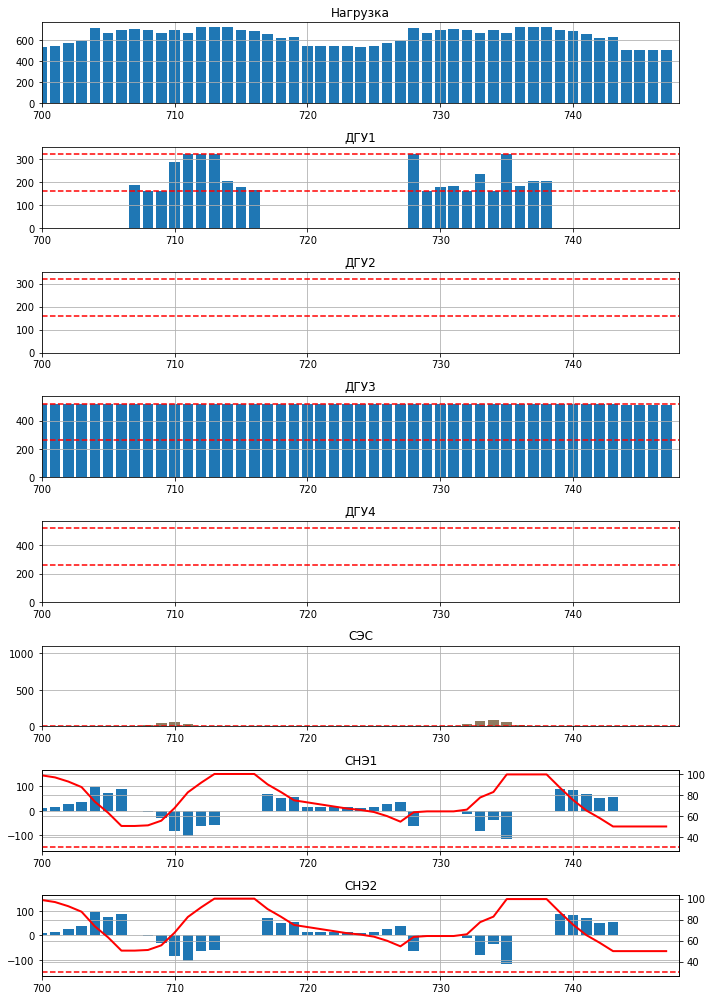

In [135]:
plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(8, 1, figsize=(10, 14))

ax[0].bar(T, [Load[t] for t in T])
ax[0].set_xlim(T1, T2)
ax[0].set_ylim(0, 1.1*700)
ax[0].plot(ax[1].get_xlim(), np.array([100, 100]), 'r--')
ax[0].plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[0].set_title('Нагрузка')

ax[1].bar(T, [m.x1[t]() for t in T])
ax[1].set_xlim(T1, T2)
ax[1].set_ylim(0, 1.1*DGU1_pmax)
ax[1].plot(ax[0].get_xlim(), np.array([DGU1_pmax, DGU1_pmax]), 'r--')
ax[1].plot(ax[0].get_xlim(), np.array([DGU1_pmin, DGU1_pmin]), 'r--')
ax[1].set_title('ДГУ1')

ax[2].bar(T, [m.x2[t]() for t in T])
ax[2].set_xlim(T1, T2)
ax[2].set_ylim(0, 1.1*DGU2_pmax)
ax[2].plot(ax[1].get_xlim(), np.array([DGU2_pmax, DGU2_pmax]), 'r--')
ax[2].plot(ax[1].get_xlim(), np.array([DGU2_pmin, DGU2_pmin]), 'r--')
ax[2].set_title('ДГУ2')

ax[3].bar(T, [m.x3[t]() for t in T])
ax[3].set_xlim(T1, T2)
ax[3].set_ylim(0, 1.1*DGU3_pmax)
ax[3].plot(ax[1].get_xlim(), np.array([DGU3_pmax, DGU3_pmax]), 'r--')
ax[3].plot(ax[1].get_xlim(), np.array([DGU3_pmin, DGU3_pmin]), 'r--')
ax[3].set_title('ДГУ3')

ax[4].bar(T, [m.x4[t]() for t in T])
ax[4].set_xlim(T1, T2)
ax[4].set_ylim(0, 1.1*DGU4_pmax)
ax[4].plot(ax[1].get_xlim(), np.array([DGU4_pmax, DGU4_pmax]), 'r--')
ax[4].plot(ax[1].get_xlim(), np.array([DGU4_pmin, DGU4_pmin]), 'r--')
ax[4].set_title('ДГУ4')

ax[5].bar(T, [m.pv1[t]()+ m.pv2[t]()+m.pv3[t]()+m.pv4[t]()+m.pv5[t]()+m.pv6[t]()+m.pv7[t]() for t in T])
ax[5].set_xlim(T1, T2)
ax[5].set_ylim(0, 1.1*1000)
ax[5].bar(T, [PV[t] for t in T], alpha=0.5)
ax[5].plot(ax[1].get_xlim(), np.array([0, 0]), 'r--')

ax[5].set_title('СЭС')

ax2 = ax[6].twinx()
ax2.plot(T, [m.soc1[t]() for t in T], color='red', linewidth=2)
ax[6].bar(T, [m.bat1_dch[t]()-m.bat1_ch[t]() for t in T])
ax[6].set_xlim(T1, T2)
ax[6].set_ylim(-1.1*150, 1.1*150)
#ax[6].plot(ax[1].get_xlim(), np.array([160, 160]), 'r--')
ax2.plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[6].set_title('СНЭ1')

ax3 = ax[7].twinx()
ax3.plot(T, [m.soc2[t]() for t in T], color='red', linewidth=2)
ax[7].bar(T, [m.bat2_dch[t]()-m.bat2_ch[t]() for t in T])
ax[7].set_xlim(T1, T2)
ax[7].set_ylim(-1.1*150, 1.1*150)
#ax[7].plot(ax[1].get_xlim(), np.array([160, 160]), 'r--')
ax3.plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[7].set_title('СНЭ2')

u1 = np.fromiter(m.u1.get_values().values(), dtype=float)
u2 = np.fromiter(m.u2.get_values().values(), dtype=float)
u3 = np.fromiter(m.u3.get_values().values(), dtype=float)
u4 = np.fromiter(m.u4.get_values().values(), dtype=float)

fig.tight_layout()
#dfout.plot(kind='bar')m = pyo.ConcreteModel()

#m.constraint.pprint()

fuel_cc = sum((0.0219*DGU1_pmax*u1 + 0.3125*dfout.d1) + (0.0219*DGU2_pmax*u2 + 0.3125*dfout.d2) + (0.049*DGU3_pmax*u3 + 0.2788*dfout.d3) + (0.049*DGU4_pmax*u4 + 0.2788*dfout.d4))

#instance.solutions.store_to(results)
#print(results)

# print(results)
print('Результаты оптимизации')
print('Оптимизированные операционные затраты за сутки: --------------------- >', '242214 руб.')
print('Суточный расход дизельного топлива: ----------------------------------- >', round(fuel_cc, 0), 'л')

In [99]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

dfout.style.background_gradient(cmap=cm)

,Load,d1,d2,d3,d4,bat1_dch,bat1_ch,bat2_dch,bat2_ch,soc1,soc2,pv1,pv2,pv3,pv4,pv5,pv6,pv7
0,547.455187,0.000000,320.000000,520.000000,0.000000,0.000000,-146.272406,0.000000,-146.272406,70.896058,70.896058,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,547.455187,0.000000,320.000000,520.000000,0.000000,0.000000,-146.272406,0.000000,-146.272406,91.792116,91.792116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,547.455187,0.000000,0.000000,520.000000,0.000000,13.727594,-0.000000,13.727594,-0.000000,89.831031,89.831031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,547.455187,0.000000,0.000000,520.000000,0.000000,13.727594,-0.000000,13.727594,-0.000000,87.869947,87.869947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,538.176286,0.000000,0.000000,520.000000,0.000000,9.088143,-0.000000,9.088143,-0.000000,86.571640,86.571640,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,547.455187,0.000000,0.000000,520.000000,0.000000,13.727594,-0.000000,13.727594,-0.000000,84.610556,84.610556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,575.291892,0.000000,0.000000,520.000000,0.000000,27.645946,-0.000000,27.645946,-0.000000,80.661135,80.661135,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,593.849694,0.000000,0.000000,520.000000,0.000000,36.924847,-0.000000,36.924847,-0.000000,75.386157,75.386157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,714.475414,0.000000,0.000000,520.000000,0.000000,97.237707,-0.000000,97.237707,-0.000000,61.495056,61.495056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,668.080906,0.000000,0.000000,520.000000,0.000000,74.040453,-0.000000,74.040453,-0.000000,50.917848,50.917848,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Результаты оптимизации
Оптимизированные операционные затраты за сутки: --------------------- > 215984 руб.
Суточный расход дизельного топлива: ----------------------------------- > 7257.0 л


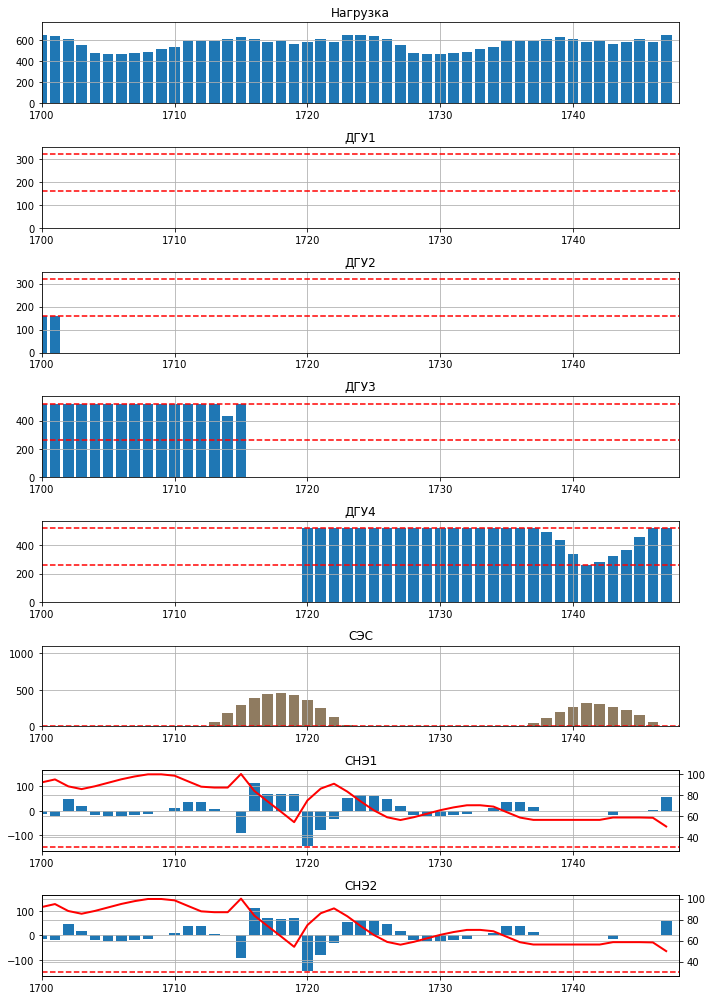

In [60]:
plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(8, 1, figsize=(10, 14))

ax[0].bar(T, [Load[t] for t in T])
ax[0].set_xlim(T1, T2)
ax[0].set_ylim(0, 1.1*700)
ax[0].plot(ax[1].get_xlim(), np.array([100, 100]), 'r--')
ax[0].plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[0].set_title('Нагрузка')

ax[1].bar(T, [m.x1[t]() for t in T])
ax[1].set_xlim(T1, T2)
ax[1].set_ylim(0, 1.1*DGU1_pmax)
ax[1].plot(ax[0].get_xlim(), np.array([DGU1_pmax, DGU1_pmax]), 'r--')
ax[1].plot(ax[0].get_xlim(), np.array([DGU1_pmin, DGU1_pmin]), 'r--')
ax[1].set_title('ДГУ1')

ax[2].bar(T, [m.x2[t]() for t in T])
ax[2].set_xlim(T1, T2)
ax[2].set_ylim(0, 1.1*DGU2_pmax)
ax[2].plot(ax[1].get_xlim(), np.array([DGU2_pmax, DGU2_pmax]), 'r--')
ax[2].plot(ax[1].get_xlim(), np.array([DGU2_pmin, DGU2_pmin]), 'r--')
ax[2].set_title('ДГУ2')

ax[3].bar(T, [m.x3[t]() for t in T])
ax[3].set_xlim(T1, T2)
ax[3].set_ylim(0, 1.1*DGU3_pmax)
ax[3].plot(ax[1].get_xlim(), np.array([DGU3_pmax, DGU3_pmax]), 'r--')
ax[3].plot(ax[1].get_xlim(), np.array([DGU3_pmin, DGU3_pmin]), 'r--')
ax[3].set_title('ДГУ3')

ax[4].bar(T, [m.x4[t]() for t in T])
ax[4].set_xlim(T1, T2)
ax[4].set_ylim(0, 1.1*DGU4_pmax)
ax[4].plot(ax[1].get_xlim(), np.array([DGU4_pmax, DGU4_pmax]), 'r--')
ax[4].plot(ax[1].get_xlim(), np.array([DGU4_pmin, DGU4_pmin]), 'r--')
ax[4].set_title('ДГУ4')

ax[5].bar(T, [m.pv1[t]()+ m.pv2[t]()+m.pv3[t]()+m.pv4[t]()+m.pv5[t]()+m.pv6[t]()+m.pv7[t]() for t in T])
ax[5].set_xlim(T1, T2)
ax[5].set_ylim(0, 1.1*1000)
ax[5].bar(T, [PV[t] for t in T], alpha=0.5)
ax[5].plot(ax[1].get_xlim(), np.array([0, 0]), 'r--')
ax[5].set_title('СЭС')

ax2 = ax[6].twinx()
ax2.plot(T, [m.soc1[t]() for t in T], color='red', linewidth=2)
ax[6].bar(T, [m.bat1_dch[t]()-m.bat1_ch[t]() for t in T])
ax[6].set_xlim(T1, T2)
ax[6].set_ylim(-1.1*150, 1.1*150)
#ax[6].plot(ax[1].get_xlim(), np.array([160, 160]), 'r--')
ax2.plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[6].set_title('СНЭ1')

ax3 = ax[7].twinx()
ax3.plot(T, [m.soc2[t]() for t in T], color='red', linewidth=2)
ax[7].bar(T, [m.bat2_dch[t]()-m.bat2_ch[t]() for t in T])
ax[7].set_xlim(T1, T2)
ax[7].set_ylim(-1.1*150, 1.1*150)
#ax[7].plot(ax[1].get_xlim(), np.array([160, 160]), 'r--')
ax3.plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[7].set_title('СНЭ2')

u1 = np.fromiter(m.u1.get_values().values(), dtype=float)
u2 = np.fromiter(m.u2.get_values().values(), dtype=float)
u3 = np.fromiter(m.u3.get_values().values(), dtype=float)
u4 = np.fromiter(m.u4.get_values().values(), dtype=float)

fig.tight_layout()
#dfout.plot(kind='bar')m = pyo.ConcreteModel()

#m.constraint.pprint()

fuel_cc = sum((0.0219*DGU1_pmax*u1 + 0.3125*dfout.d1) + (0.0219*DGU2_pmax*u2 + 0.3125*dfout.d2) + (0.049*DGU3_pmax*u3 + 0.2788*dfout.d3) + (0.049*DGU4_pmax*u4 + 0.2788*dfout.d4))

#instance.solutions.store_to(results)
#print(results)

# print(results)
print('Результаты оптимизации')
print('Оптимизированные операционные затраты за сутки: --------------------- >', '215984 руб.')
print('Суточный расход дизельного топлива: ----------------------------------- >', round(fuel_cc, 0), 'л')

In [59]:
opt =  pyo.SolverFactory('knitroampl')
#opt.options['parallel/mode'] = 1
#opt.options['parallel/minnthreads'] = 1
#opt.options['parallel/maxnthreads'] = 4
#opt.options['limits/gap'] = 0.05


results = opt.solve(m, logfile=r'C:\Users\Narynbaev\Documents\Оптимизация Верхоянск\couenne_logg.log', tee=True, keepfiles=True)
results.write()
#pyo.SolverFactory('mindtpy').solve(m, mip_solver='cbc', nlp_solver='ipopt', tee=True).write()

# Extract model output in list
Date = list(Load[T].index)
output.append([Date, m.x1.get_values().values(), m.x2.get_values().values(), 
                m.x3.get_values().values(), m.x4.get_values().values(), m.bat1_dch.get_values().values(),
              m.bat1_ch.get_values().values()]) 
                #m.bat1_dch.get_values().values(), m.bat1_ch.get_values().values(), ])


dfout = pd.DataFrame()
#dfout.index=Load[T].index
dfout['Load'] = Load[T1:T2]
dfout['d1'] = m.x1.get_values().values()
dfout['d2'] = m.x2.get_values().values()
dfout['d3'] = m.x3.get_values().values()
dfout['d4'] = m.x4.get_values().values()
# dfout['d1_suc'] = m.suc1.get_values().values()
# dfout['d2_suc'] = m.suc2.get_values().values()
# dfout['d3_suc'] = m.suc3.get_values().values()
# dfout['d4_suc'] = m.suc4.get_values().values()
# dfout['d1_sdc'] = m.sdc1.get_values().values()
# dfout['d2_sdc'] = m.sdc2.get_values().values()
# dfout['d3_sdc'] = m.sdc3.get_values().values()
# dfout['d4_sdc'] = m.sdc4.get_values().values()
dfout['bat1_dch'] = m.bat1_dch.get_values().values()
dfout['bat1_ch'] = m.bat1_ch.get_values().values()
dfout['bat2_dch'] = m.bat2_dch.get_values().values()
dfout['bat2_ch'] = m.bat2_ch.get_values().values()
dfout['soc1'] = m.soc1.get_values().values()
dfout['soc2'] = m.soc2.get_values().values()
dfout['pv1'] = m.PV1.get_values().values()
dfout['pv2'] = m.PV2.get_values().values()
dfout['pv3'] = m.PV3.get_values().values()
dfout['pv4'] = m.PV4.get_values().values()
dfout['pv5'] = m.PV5.get_values().values()
dfout['pv6'] = m.PV6.get_values().values()
dfout['pv7'] = m.PV7.get_values().values()
dfout['bat1_ch'] = -dfout['bat1_ch']
dfout['bat2_ch'] = -dfout['bat2_ch']
#dfout['dd1'] = m.u1.get_values().values()

dfout.index = Load[T1:T2].index
dfout['Load'] = Load[T1:T2]


Solver log file: 'C:\Users\Narynbaev\Documents\Оптимизация Верхоянск\couenne_logg.log'
Solver solution file: 'C:\Users\NARYNB~1\AppData\Local\Temp\tmpzw84gk7j.pyomo.sol'
Solver problem files: ('C:\\Users\\NARYNB~1\\AppData\\Local\\Temp\\tmpzw84gk7j.pyomo.nl',)
Artelys Knitro 12.4.0: WARNING: Constraint c[1728] is constant or undefined and will be ignored.



             Trial License
       (NOT FOR COMMERCIAL USE)
         Artelys Knitro 12.4.0

MINLP solver shifted start point to satisfy bounds (18 variables).
         The Knitro mixed integer solver is designed for convex problems.
         For non-convex problems it is only a heuristic, and the reported
         bounds and optimality claims cannot be verified.

datacheck:               0
hessian_no_f:            1
par_concurrent_evals:    0
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 1.
Knitro changing mip_rounding from AUTO to 3.
Knitro changing mip_heuristic_strategy from AUTO to 1.
Knitro changing mip_heuristic_feaspump from AUTO to 1.
Knitro changing mip_heuristic_mpec from AUTO to 0.
Knitro changing mip_heuristic_diving from AUT

Knitro solving root node relaxation
Knitro using Branch and Bound method.

   Node    Left    Iinf     Objective         Best Relaxatn  Best Incumbent
  ------  ------  ------  --------------     --------------  --------------
       1       0     151    6.156550e+05       6.156550e+05    4.479007e+05

EXIT: All nodes have been explored. Integer feasible point found.

Final Statistics for MIP
------------------------
Final objective value               =   4.47900676864434e+05
Final integrality gap (abs / rel)   =  1.68e+05 /   3.75e-01 (37.45%)
# of nodes processed                =        1
# of subproblems processed          =        2
# of cuts                           =        1
  # of mixed integer rounding cuts  =        1
Total program time (secs)           =       1.368 (     1.139 CPU time)
Time spent in evaluations (secs)    =       0.000


WARNING: Loading a SolverResults object with a warning status into
    model.name="unknown";
      - termination condition: maxIteratio

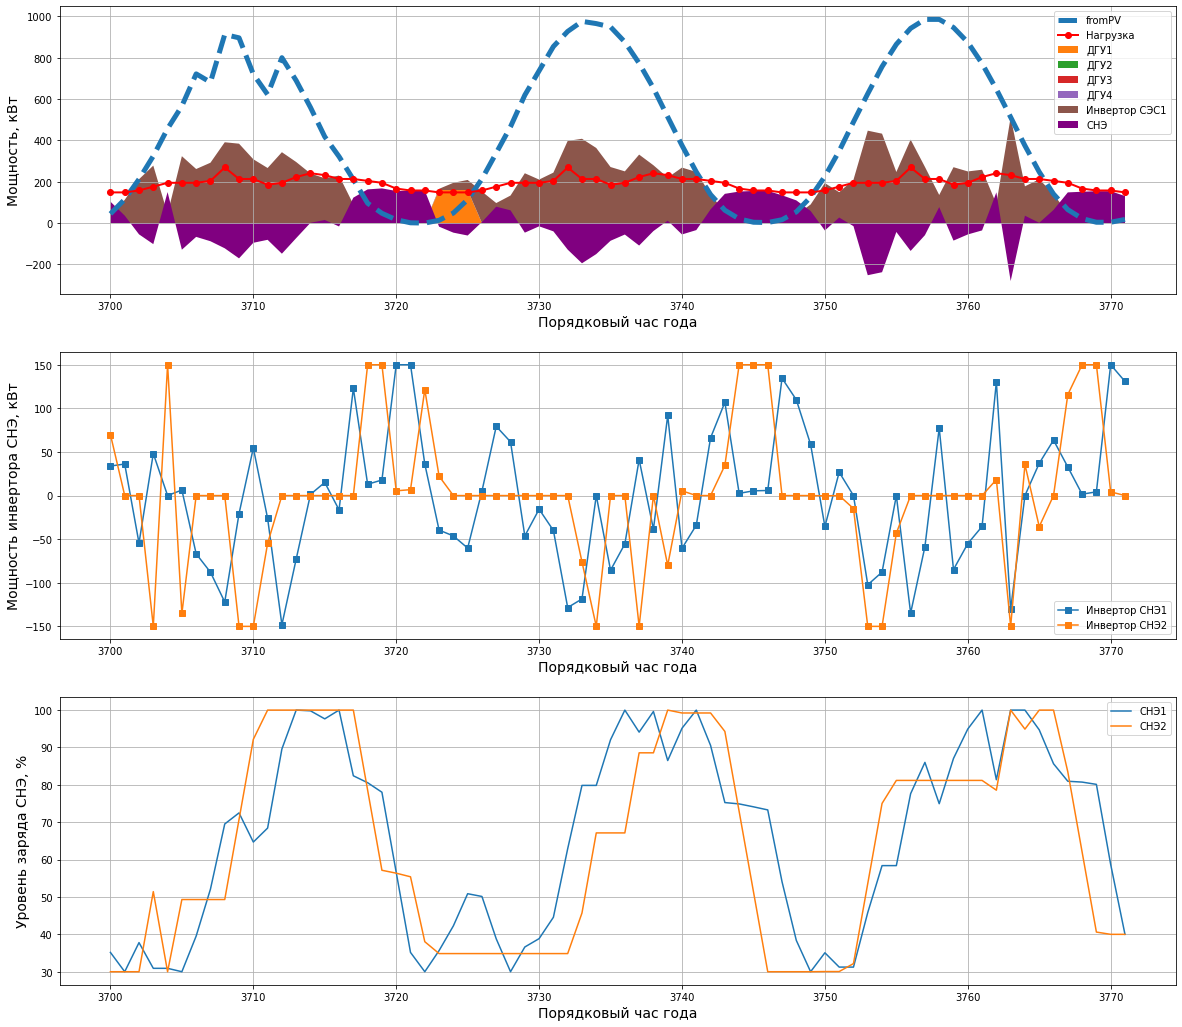

In [37]:
#графики

t1 = 0
t2 = 72

fig, ax = plt.subplots(3, figsize=(20, 18))
#(dfout*1000)[t1:t2].plot(ax=ax[0],marker='^')
ax[0].plot((Load[T1:T2]).index[t1:t2], PV[T1:T2][t1:t2], '--',label='fromPV', linewidth=5)
ax[2].plot((Load[T1:T2]).index[t1:t2], dfout['soc1'][t1:t2], label='СНЭ1')
ax[2].plot((Load[T1:T2]).index[t1:t2], dfout['soc2'][t1:t2], label='СНЭ2')
#ax[3].plot((Load[T1:T2]).index[t1:t2], Load[T1:T2][t1:t2], label='Load', marker='o')
ax[1].plot((Load[T1:T2]).index[t1:t2], (dfout['bat1_dch']+dfout['bat1_ch'])[t1:t2], label='Инвертор СНЭ1', marker='s')
ax[1].plot((Load[T1:T2]).index[t1:t2], (dfout['bat2_dch']+dfout['bat2_ch'])[t1:t2], label='Инвертор СНЭ2', marker='s')

ax[0].set_xlabel('Порядковый час года', fontsize=14)
ax[0].set_ylabel('Мощность, кВт', fontsize=14)
#ax[1].plot(nu.stores_t.p.index[t1:t2], (nu.stores_t.p*1000)[t1:t2], label = 'Storage')
ax[1].set_xlabel('Порядковый час года', fontsize=14)
ax[1].set_ylabel('Мощность инвертора СНЭ, кВт', fontsize=14)
ax[2].set_xlabel('Порядковый час года', fontsize=14)
ax[2].set_ylabel('Уровень заряда СНЭ, %', fontsize=14)

#ax[3].set_xlabel('Порядковый час года', fontsize=14)
#ax[3].set_ylabel('Мощность, кВт', fontsize=14)
#ax[1].plot(nu.stores_t.p.index[t1:t2], (nu.stores_t.p*1000)[t1:t2], label = 'Storage')
#ax[4].set_xlabel('Порядковый час года', fontsize=14)
#ax[4].set_ylabel('Мощность, кВт', fontsize=14)


#ax[1].plot(poa.index, tmy['ghi'], label = 'GHI')
ax[1].legend(loc='best')
ax[0].legend(loc='best')



ax[0].plot((Load[T1:T2]).index[t1:t2], Load[T1:T2][t1:t2], label='Нагрузка', marker='o', color='red', linewidth=2)

labels = ["ДГУ1", "ДГУ2", "ДГУ3", "ДГУ4", "Инвертор СЭС1", "Инвертор СЭС2", "Инвертор СЭС3", "Инвертор СЭС4",
         "Инвертор СЭС5", "Инвертор СЭС6", "Инвертор СЭС7"]

ax[0].stackplot((Load[T1:T2]).index[t1:t2], (dfout['d1'])[t1:t2],
                (dfout['d2'])[t1:t2],(dfout['d3'])[t1:t2],
                (dfout['d4'])[t1:t2],
                (dfout['pv1']+dfout['pv2']+dfout['pv3']+dfout['pv4']+dfout['pv5']+dfout['pv6']+dfout['pv7'])[t1:t2],
               baseline ='zero', labels=labels) #labels=labels
ax[0].stackplot((Load[T1:T2]).index[t1:t2], (dfout['bat1_dch']+dfout['bat2_dch'])[t1:t2]+(dfout['bat1_ch']+dfout['bat2_ch'])[t1:t2],
               baseline ='zero', colors = ['purple'],labels=['СНЭ'])

# ax[0].stackplot((Load[T1:T2]).index[t1:t2], (dfout['bat1_ch'])[t1:t2],
#                baseline ='zero', colors = ['purple'],labels=['СНЭ1 заряд'])
# ax[0].stackplot((Load[T1:T2]).index[t1:t2], (nu.stores_t.p['Battery Storage 2']*1000)[t1:t2],
#                baseline ='zero', colors =['brown'], labels=['СНЭ2'])


#colors =['orange', 'blue', 'green']




# ax[3].bar((Load[T1:T2]).index[t1:t2], 952*(poa_global/poa_global.max())[T1:T2][t1:t2], 
#           label='Прогнозная мощность\nвсего массива ФЭМ', alpha=0.5, edgecolor = "black")
# ax[3].plot((Load[T1:T2]).index[t1:t2], Load[T1:T2][t1:t2], label='Нагрузка', marker='o', color='red', linewidth=2)
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar1']*1000)[t1:t2], label='Инвертор СЭС1', edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar2']*1000)[t1:t2], label='Инвертор СЭС2',
#          bottom=(dfout['solar1']*1000)[t1:t2], edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar3']*1000)[t1:t2], label='Инвертор СЭС3',
#          bottom=(dfout['solar1']*1000)[t1:t2]+(dfout['solar2']*1000)[t1:t2],
#          edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar4']*1000)[t1:t2], label='Инвертор СЭС4',
#          bottom=(dfout['solar1']*1000)[t1:t2]+(dfout['solar2']*1000)[t1:t2]+
#           (dfout['solar3']*1000)[t1:t2], edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar5']*1000)[t1:t2], label='Инвертор СЭС5',
#          bottom=(dfout['solar1']*1000)[t1:t2]+(dfout['solar2']*1000)[t1:t2]+
#           (dfout['solar3']*1000)[t1:t2]+(dfout['solar4']*1000)[t1:t2],
#          edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar6']*1000)[t1:t2], label='Инвертор СЭС6',
#          bottom=(dfout['solar1']*1000)[t1:t2]+(dfout['solar2']*1000)[t1:t2]+
#           (dfout['solar3']*1000)[t1:t2]+(dfout['solar4']*1000)[t1:t2]+
#           (dfout['solar5']*1000)[t1:t2], edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar7']*1000)[t1:t2], label='Инвертор СЭС7',
#          bottom=(dfout['solar1']*1000)[t1:t2]+(dfout['solar2']*1000)[t1:t2]+
#           (dfout['solar3']*1000)[t1:t2]+(dfout['solar4']*1000)[t1:t2]+
#           (dfout['solar5']*1000)[t1:t2]+(dfout['solar6']*1000)[t1:t2],
#          edgecolor = "black")


# ax[4].plot((Load[T1:T2]).index[t1:t2], Load[T1:T2][t1:t2], label='Нагрузка', marker='o', color='red', linewidth=2)
# ax[4].bar((Load[T1:T2]).index[t1:t2],(dfout['d1']*1000)[t1:t2], label='ДГУ1', edgecolor = "black")
# ax[4].bar((Load[T1:T2]).index[t1:t2],(dfout['d2']*1000)[t1:t2], label='ДГУ2',
#          bottom=(dfout['d1']*1000)[t1:t2], edgecolor = "black")
# ax[4].bar((Load[T1:T2]).index[t1:t2],(dfout['d3']*1000)[t1:t2], label='ДГУ3', edgecolor = "black",
#          bottom=(dfout['d1']*1000)[t1:t2]+(dfout['d2']*1000)[t1:t2])
# ax[4].bar((Load[T1:T2]).index[t1:t2],(dfout['d4']*1000)[t1:t2], label='ДГУ4',
#          bottom=(dfout['d1']*1000)[t1:t2]+(dfout['d2']*1000)[t1:t2]+
#           +(dfout['d3']*1000)[t1:t2],
#           edgecolor = "black")
# ax[4].bar((Load[T1:T2]).index[t1:t2],(nu.stores_t.p['Battery Storage 1']*1000)[t1:t2], label='СНЭ1',
#          edgecolor = "black", width=0.4)
# ax[4].bar((Load[T1:T2]).index[t1:t2],(nu.stores_t.p['Battery Storage 2']*1000)[t1:t2], label='СНЭ2',
#          bottom=(nu.stores_t.p['Battery Storage 1']*1000)[t1:t2],
#           edgecolor = "black", width=0.4)



# ax[0].grid()
# ax[1].grid()
# ax[2].grid()
# ax[3].grid()
# ax[4].grid()
ax[0].legend(loc='best')
ax[2].legend(loc='best')
# ax[3].legend(loc='best')
# ax[4].legend(loc='best')

plt.show()

### Пример 2. Зима (полярная ночь) - СНЭ законсервированы

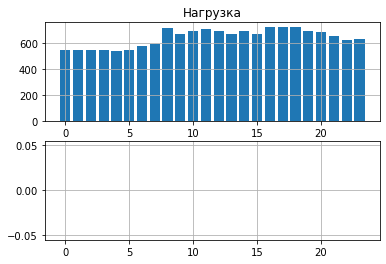

    'pyomo.core.base.set.OrderedSimpleSet'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.set.AbstractOrderedSimpleSet'>).
    This is usually indicative of a modelling error. To avoid this warning,
    use block.del_component() and block.add_component().
    'pyomo.core.base.set.OrderedSimpleSet'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.set.AbstractOrderedSimpleSet'>).
    This is usually indicative of a modelling error. To avoid this warning,
    use block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a model

    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
 

    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
 

    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'py

In [45]:
# demand
T1 = 0 #1700, 3700, 3865, 1875, 3605
T2 = 24 #1724, 3724, 3915, 1920, 3650

T = np.array([t for t in range(T1, T2)])

fig, ax = plt.subplots(2,1)
ax[0].bar(Load[T].index, Load[T])
ax[0].set_xlabel('Временной период')
ax[0].set_title('Нагрузка')
ax[1].bar(PV[T].index, PV[T])
ax[0].set_xlabel('Временной период')
ax[0].set_title('Нагрузка')
plt.show()

output = []

d1_up_before = 0
d2_up_before = 0
d3_up_before = 1
d4_up_before = 1

d1_down_before = 3
d2_down_before = 3
d3_down_before = 2
d4_down_before = 2

u1_start = 0
u2_start = 0
u3_start = 1
u4_start = 1

d1_availability_state = 1
d2_availability_state = 1
d3_availability_state = 1
d4_availability_state = 1

d1_min_up_time = 3
d2_min_up_time = 3 
d3_min_up_time = 3 
d4_min_up_time = 3

d1_min_down_time = 3
d2_min_down_time = 3 
d3_min_down_time = 3 
d4_min_down_time = 3 

ess1_availability_state = 0
ess2_availability_state = 0

soc1_before = 30
soc2_before = 30

m = unit_commitment()

results = pyo.SolverFactory('couenne').solve(m, logfile='FILENAME.log', tee=True)
results.write()
#pyo.SolverFactory('mindtpy').solve(m, mip_solver='cbc', nlp_solver='ipopt', tee=True).write()

# Extract model output in list
Date = list(Load[T].index)
output.append([Date, m.x1.get_values().values(), m.x2.get_values().values(), 
                m.x3.get_values().values(), m.x4.get_values().values(), m.bat1_dch.get_values().values(),
              m.bat1_ch.get_values().values()]) 
                #m.bat1_dch.get_values().values(), m.bat1_ch.get_values().values(), ])


dfout = pd.DataFrame()
#dfout.index=Load[T].index
dfout['Load'] = Load[T1:T2]
dfout['d1'] = m.x1.get_values().values()
dfout['d2'] = m.x2.get_values().values()
dfout['d3'] = m.x3.get_values().values()
dfout['d4'] = m.x4.get_values().values()
# dfout['d1_suc'] = m.suc1.get_values().values()
# dfout['d2_suc'] = m.suc2.get_values().values()
# dfout['d3_suc'] = m.suc3.get_values().values()
# dfout['d4_suc'] = m.suc4.get_values().values()
# dfout['d1_sdc'] = m.sdc1.get_values().values()
# dfout['d2_sdc'] = m.sdc2.get_values().values()
# dfout['d3_sdc'] = m.sdc3.get_values().values()
# dfout['d4_sdc'] = m.sdc4.get_values().values()
dfout['bat1_dch'] = m.bat1_dch.get_values().values()
dfout['bat1_ch'] = m.bat1_ch.get_values().values()
dfout['bat2_dch'] = m.bat2_dch.get_values().values()
dfout['bat2_ch'] = m.bat2_ch.get_values().values()
dfout['soc1'] = m.soc1.get_values().values()
dfout['soc2'] = m.soc2.get_values().values()
dfout['pv1'] = m.PV1.get_values().values()
dfout['pv2'] = m.PV2.get_values().values()
dfout['pv3'] = m.PV3.get_values().values()
dfout['pv4'] = m.PV4.get_values().values()
dfout['pv5'] = m.PV5.get_values().values()
dfout['pv6'] = m.PV6.get_values().values()
dfout['pv7'] = m.PV7.get_values().values()
dfout['bat1_ch'] = -dfout['bat1_ch']
dfout['bat2_ch'] = -dfout['bat2_ch']
#dfout['dd1'] = m.u1.get_values().values()

dfout.index = Load[T1:T2].index
dfout['Load'] = Load[T1:T2]

Результаты оптимизации
Оптимизированные операционные затраты за сутки: --------------------- > 239651 руб.
Суточный расход дизельного топлива: ----------------------------------- > 5981.0 л


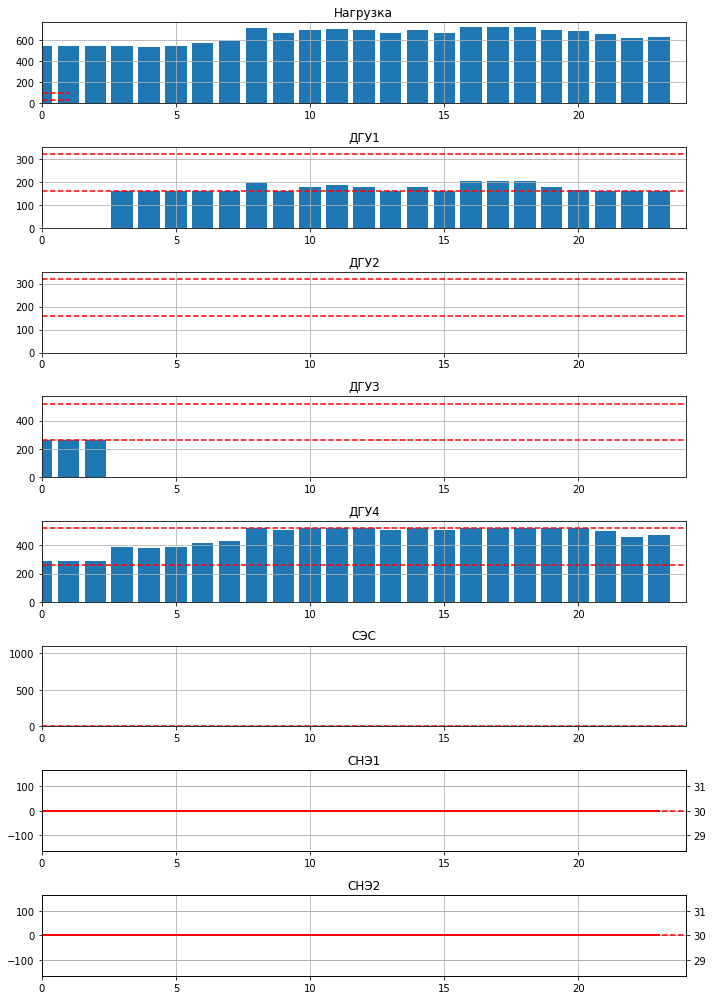

In [47]:
plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(8, 1, figsize=(10, 14))

ax[0].bar(T, [Load[t] for t in T])
ax[0].set_xlim(T1, T2)
ax[0].set_ylim(0, 1.1*700)
ax[0].plot(ax[1].get_xlim(), np.array([100, 100]), 'r--')
ax[0].plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[0].set_title('Нагрузка')

ax[1].bar(T, [m.x1[t]() for t in T])
ax[1].set_xlim(T1, T2)
ax[1].set_ylim(0, 1.1*DGU1_pmax)
ax[1].plot(ax[0].get_xlim(), np.array([DGU1_pmax, DGU1_pmax]), 'r--')
ax[1].plot(ax[0].get_xlim(), np.array([DGU1_pmin, DGU1_pmin]), 'r--')
ax[1].set_title('ДГУ1')

ax[2].bar(T, [m.x2[t]() for t in T])
ax[2].set_xlim(T1, T2)
ax[2].set_ylim(0, 1.1*DGU2_pmax)
ax[2].plot(ax[1].get_xlim(), np.array([DGU2_pmax, DGU2_pmax]), 'r--')
ax[2].plot(ax[1].get_xlim(), np.array([DGU2_pmin, DGU2_pmin]), 'r--')
ax[2].set_title('ДГУ2')

ax[3].bar(T, [m.x3[t]() for t in T])
ax[3].set_xlim(T1, T2)
ax[3].set_ylim(0, 1.1*DGU3_pmax)
ax[3].plot(ax[1].get_xlim(), np.array([DGU3_pmax, DGU3_pmax]), 'r--')
ax[3].plot(ax[1].get_xlim(), np.array([DGU3_pmin, DGU3_pmin]), 'r--')
ax[3].set_title('ДГУ3')

ax[4].bar(T, [m.x4[t]() for t in T])
ax[4].set_xlim(T1, T2)
ax[4].set_ylim(0, 1.1*DGU4_pmax)
ax[4].plot(ax[1].get_xlim(), np.array([DGU4_pmax, DGU4_pmax]), 'r--')
ax[4].plot(ax[1].get_xlim(), np.array([DGU4_pmin, DGU4_pmin]), 'r--')
ax[4].set_title('ДГУ4')

ax[5].bar(T, [m.pv1[t]()+ m.pv2[t]()+m.pv3[t]()+m.pv4[t]()+m.pv5[t]()+m.pv6[t]()+m.pv7[t]() for t in T])
ax[5].set_xlim(T1, T2)
ax[5].set_ylim(0, 1.1*1000)
ax[5].bar(T, [PV[t] for t in T], alpha=0.5)
ax[5].plot(ax[1].get_xlim(), np.array([0, 0]), 'r--')
ax[5].set_title('СЭС')

ax2 = ax[6].twinx()
ax2.plot(T, [m.soc1[t]() for t in T], color='red', linewidth=2)
ax[6].bar(T, [m.bat1_dch[t]()-m.bat1_ch[t]() for t in T])
ax[6].set_xlim(T1, T2)
ax[6].set_ylim(-1.1*150, 1.1*150)
#ax[6].plot(ax[1].get_xlim(), np.array([160, 160]), 'r--')
ax2.plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[6].set_title('СНЭ1')

ax3 = ax[7].twinx()
ax3.plot(T, [m.soc2[t]() for t in T], color='red', linewidth=2)
ax[7].bar(T, [m.bat2_dch[t]()-m.bat2_ch[t]() for t in T])
ax[7].set_xlim(T1, T2)
ax[7].set_ylim(-1.1*150, 1.1*150)
#ax[7].plot(ax[1].get_xlim(), np.array([160, 160]), 'r--')
ax3.plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[7].set_title('СНЭ2')



fig.tight_layout()
#dfout.plot(kind='bar')m = pyo.ConcreteModel()

#m.constraint.pprint()

fuel_cc = sum((0.0219*DGU1_pmax + 0.3125*dfout.d1) + (0.0219*DGU2_pmax + 0.3125*dfout.d2) + (0.049*DGU3_pmax + 0.2788*dfout.d3) + (0.049*DGU4_pmax + 0.2788*dfout.d4))

# print(results)
print('Результаты оптимизации')
print('Оптимизированные операционные затраты за сутки: --------------------- >', '239651 руб.')
print('Суточный расход дизельного топлива: ----------------------------------- >', round(fuel_cc, 0), 'л')

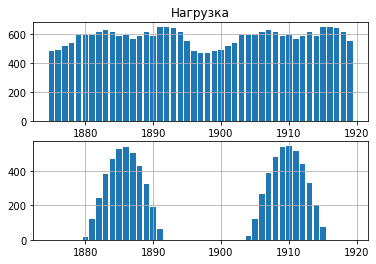

    'pyomo.core.base.set.OrderedSimpleSet'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.set.AbstractOrderedSimpleSet'>).
    This is usually indicative of a modelling error. To avoid this warning,
    use block.del_component() and block.add_component().
    'pyomo.core.base.set.OrderedSimpleSet'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.set.AbstractOrderedSimpleSet'>).
    This is usually indicative of a modelling error. To avoid this warning,
    use block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a model

    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
 

    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
 

    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'py

In [327]:
# demand
T1 = 1875 #1700, 3700, 3865, 1875, 3605
T2 = 1920 #1724, 3724, 3915, 1920, 3650

T = np.array([t for t in range(T1, T2)])

fig, ax = plt.subplots(2,1)
ax[0].bar(Load[T].index, Load[T])
ax[0].set_xlabel('Временной период')
ax[0].set_title('Нагрузка')
ax[1].bar(PV[T].index, PV[T])
ax[0].set_xlabel('Временной период')
ax[0].set_title('Нагрузка')
plt.show()

output = []

d1_up_before = 0
d2_up_before = 0
d3_up_before = 1
d4_up_before = 1

d1_down_before = 3
d2_down_before = 3
d3_down_before = 2
d4_down_before = 2

u1_start = 0
u2_start = 0
u3_start = 1
u4_start = 1

d1_availability_state = 1
d2_availability_state = 1
d3_availability_state = 1
d4_availability_state = 1

d1_min_up_time = 3
d2_min_up_time = 3 
d3_min_up_time = 3 
d4_min_up_time = 3

d1_min_down_time = 3
d2_min_down_time = 3 
d3_min_down_time = 3 
d4_min_down_time = 3 

ess1_availability_state = 1
ess2_availability_state = 1

soc1_before = 30
soc2_before = 30

m = unit_commitment()

pyo.SolverFactory('couenne').solve(m, logfile='FILENAME.log', tee=True).write()
#pyo.SolverFactory('mindtpy').solve(m, mip_solver='cbc', nlp_solver='ipopt', tee=True).write()

# Extract model output in list
Date = list(Load[T].index)
output.append([Date, m.x1.get_values().values(), m.x2.get_values().values(), 
                m.x3.get_values().values(), m.x4.get_values().values(), m.bat1_dch.get_values().values(),
              m.bat1_ch.get_values().values()]) 
                #m.bat1_dch.get_values().values(), m.bat1_ch.get_values().values(), ])


dfout = pd.DataFrame()
#dfout.index=Load[T].index
dfout['Load'] = Load[T1:T2]
dfout['d1'] = m.x1.get_values().values()
dfout['d2'] = m.x2.get_values().values()
dfout['d3'] = m.x3.get_values().values()
dfout['d4'] = m.x4.get_values().values()
# dfout['d1_suc'] = m.suc1.get_values().values()
# dfout['d2_suc'] = m.suc2.get_values().values()
# dfout['d3_suc'] = m.suc3.get_values().values()
# dfout['d4_suc'] = m.suc4.get_values().values()
# dfout['d1_sdc'] = m.sdc1.get_values().values()
# dfout['d2_sdc'] = m.sdc2.get_values().values()
# dfout['d3_sdc'] = m.sdc3.get_values().values()
# dfout['d4_sdc'] = m.sdc4.get_values().values()
dfout['bat1_dch'] = m.bat1_dch.get_values().values()
dfout['bat1_ch'] = m.bat1_ch.get_values().values()
dfout['bat2_dch'] = m.bat2_dch.get_values().values()
dfout['bat2_ch'] = m.bat2_ch.get_values().values()
dfout['soc1'] = m.soc1.get_values().values()
dfout['soc2'] = m.soc2.get_values().values()
dfout['pv1'] = m.PV1.get_values().values()
dfout['pv2'] = m.PV2.get_values().values()
dfout['pv3'] = m.PV3.get_values().values()
dfout['pv4'] = m.PV4.get_values().values()
dfout['pv5'] = m.PV5.get_values().values()
dfout['pv6'] = m.PV6.get_values().values()
dfout['pv7'] = m.PV7.get_values().values()
dfout['bat1_ch'] = -dfout['bat1_ch']
dfout['bat2_ch'] = -dfout['bat2_ch']
#dfout['dd1'] = m.u1.get_values().values()

dfout.index = Load[T1:T2].index
dfout['Load'] = Load[T1:T2]



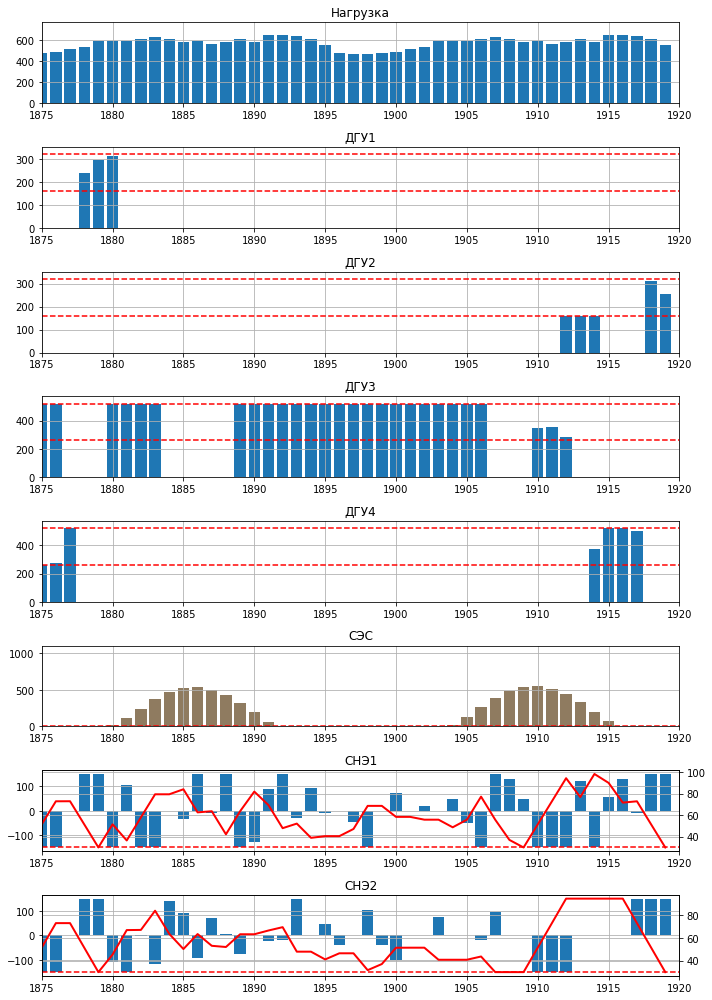

In [328]:
plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(8, 1, figsize=(10, 14))

ax[0].bar(T, [Load[t] for t in T])
ax[0].set_xlim(T1, T2)
ax[0].set_ylim(0, 1.1*700)
ax[0].plot(ax[1].get_xlim(), np.array([100, 100]), 'r--')
ax[0].plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[0].set_title('Нагрузка')

ax[1].bar(T, [m.x1[t]() for t in T])
ax[1].set_xlim(T1, T2)
ax[1].set_ylim(0, 1.1*DGU1_pmax)
ax[1].plot(ax[0].get_xlim(), np.array([DGU1_pmax, DGU1_pmax]), 'r--')
ax[1].plot(ax[0].get_xlim(), np.array([DGU1_pmin, DGU1_pmin]), 'r--')
ax[1].set_title('ДГУ1')

ax[2].bar(T, [m.x2[t]() for t in T])
ax[2].set_xlim(T1, T2)
ax[2].set_ylim(0, 1.1*DGU2_pmax)
ax[2].plot(ax[1].get_xlim(), np.array([DGU2_pmax, DGU2_pmax]), 'r--')
ax[2].plot(ax[1].get_xlim(), np.array([DGU2_pmin, DGU2_pmin]), 'r--')
ax[2].set_title('ДГУ2')

ax[3].bar(T, [m.x3[t]() for t in T])
ax[3].set_xlim(T1, T2)
ax[3].set_ylim(0, 1.1*DGU3_pmax)
ax[3].plot(ax[1].get_xlim(), np.array([DGU3_pmax, DGU3_pmax]), 'r--')
ax[3].plot(ax[1].get_xlim(), np.array([DGU3_pmin, DGU3_pmin]), 'r--')
ax[3].set_title('ДГУ3')

ax[4].bar(T, [m.x4[t]() for t in T])
ax[4].set_xlim(T1, T2)
ax[4].set_ylim(0, 1.1*DGU4_pmax)
ax[4].plot(ax[1].get_xlim(), np.array([DGU4_pmax, DGU4_pmax]), 'r--')
ax[4].plot(ax[1].get_xlim(), np.array([DGU4_pmin, DGU4_pmin]), 'r--')
ax[4].set_title('ДГУ4')

ax[5].bar(T, [m.pv1[t]()+ m.pv2[t]()+m.pv3[t]()+m.pv4[t]()+m.pv5[t]()+m.pv6[t]()+m.pv7[t]() for t in T])
ax[5].set_xlim(T1, T2)
ax[5].set_ylim(0, 1.1*1000)
ax[5].bar(T, [PV[t] for t in T], alpha=0.5)
ax[5].plot(ax[1].get_xlim(), np.array([0, 0]), 'r--')
ax[5].set_title('СЭС')

ax2 = ax[6].twinx()
ax2.plot(T, [m.soc1[t]() for t in T], color='red', linewidth=2)
ax[6].bar(T, [m.bat1_dch[t]()-m.bat1_ch[t]() for t in T])
ax[6].set_xlim(T1, T2)
ax[6].set_ylim(-1.1*150, 1.1*150)
#ax[6].plot(ax[1].get_xlim(), np.array([160, 160]), 'r--')
ax2.plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[6].set_title('СНЭ1')

ax3 = ax[7].twinx()
ax3.plot(T, [m.soc2[t]() for t in T], color='red', linewidth=2)
ax[7].bar(T, [m.bat2_dch[t]()-m.bat2_ch[t]() for t in T])
ax[7].set_xlim(T1, T2)
ax[7].set_ylim(-1.1*150, 1.1*150)
#ax[7].plot(ax[1].get_xlim(), np.array([160, 160]), 'r--')
ax3.plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[7].set_title('СНЭ2')



fig.tight_layout()
#dfout.plot(kind='bar')m = pyo.ConcreteModel()

#m.constraint.pprint()

In [329]:
cm = sns.light_palette("green", as_cmap=True)

dfout.style.background_gradient(cmap=cm)

,Load,d1,d2,d3,d4,bat1_dch,bat1_ch,bat2_dch,bat2_ch,soc1,soc2,pv1,pv2,pv3,pv4,pv5,pv6,pv7
1875,482.502877,0.000000,0.000000,520.000000,262.502877,0.000000,-150.000000,0.000000,-150.000000,51.428571,51.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1876,491.781778,0.000000,0.000000,520.000000,271.781778,0.000000,-150.000000,0.000000,-150.000000,72.857143,72.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1877,519.618483,0.000000,0.000000,0.000000,520.000000,0.000000,-0.381517,0.000000,-0.000000,72.911645,72.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1878,538.176286,238.176286,0.000000,0.000000,0.000000,150.000000,-0.000000,150.000000,-0.000000,51.483074,51.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1879,593.849694,293.849694,0.000000,0.000000,0.000000,150.000000,-0.000000,150.000000,-0.000000,30.054502,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1880,593.849694,312.347145,0.000000,520.000000,0.000000,0.000000,-150.000000,0.000000,-107.425451,51.483074,45.346493,2.704000,2.704000,2.704000,2.704000,2.704000,2.704000,2.704000
1881,593.849694,0.000000,0.000000,520.000000,0.000000,104.873694,-0.000000,0.000000,-150.000000,36.501118,66.775064,16.996571,16.996571,16.996571,16.996571,16.996571,16.996571,16.996571
1882,612.407497,0.000000,0.000000,520.000000,0.000000,0.000000,-150.000000,0.000000,-0.952503,57.929689,66.911136,34.765714,34.765714,34.765714,34.765714,34.765714,34.765714,34.765714
1883,630.965300,0.000000,0.000000,520.000000,0.000000,0.000000,-150.000000,0.000000,-117.594700,79.358260,83.710379,54.080000,54.080000,54.080000,54.080000,54.080000,54.080000,54.080000
1884,612.407497,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,141.911497,-0.000000,79.358260,63.437308,67.213714,67.213714,67.213714,67.213714,67.213714,67.213714,67.213714


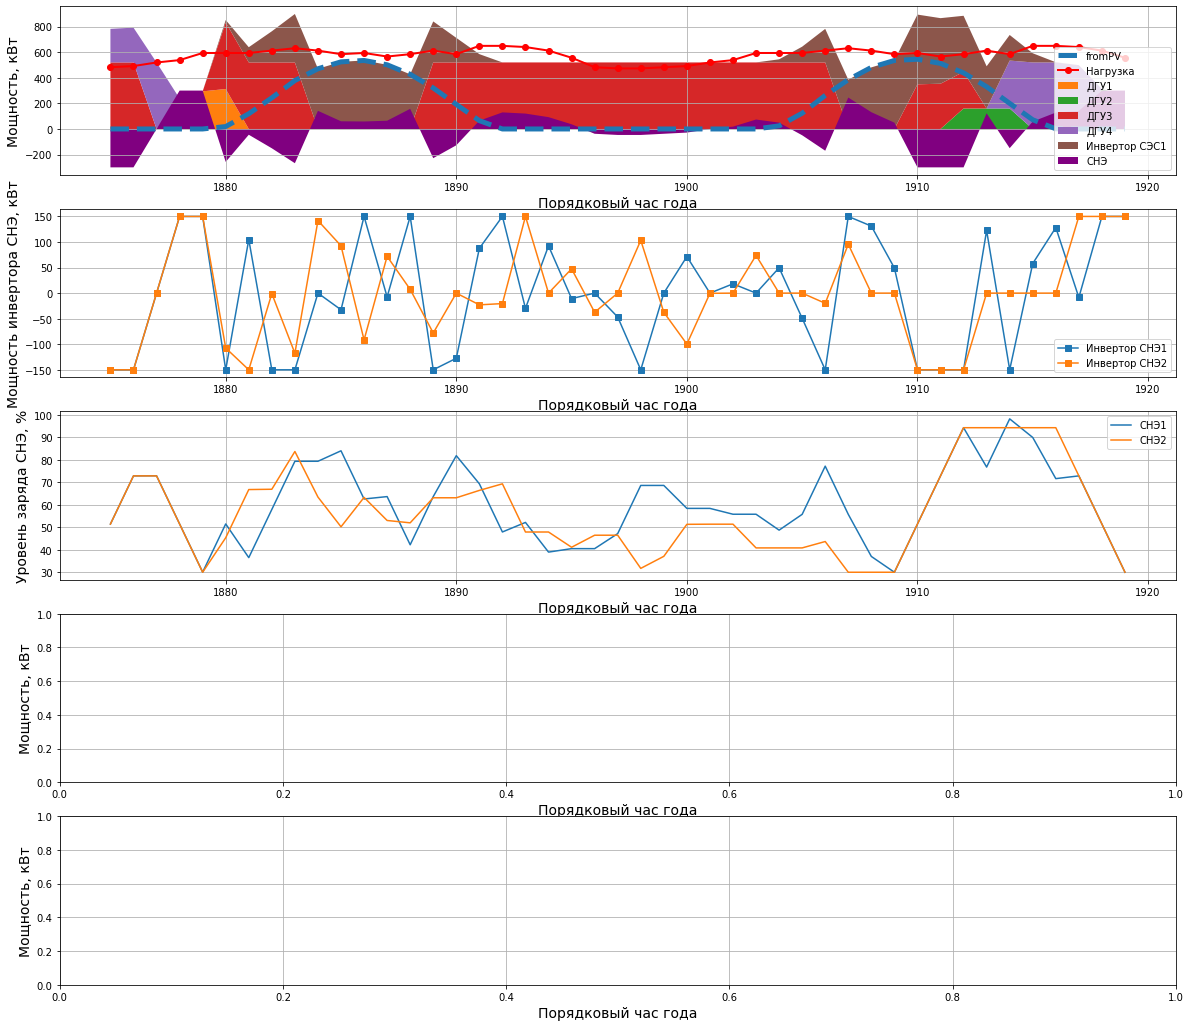

In [330]:
#графики

t1 = 0
t2 = 48

fig, ax = plt.subplots(5, figsize=(20, 18))
#(dfout*1000)[t1:t2].plot(ax=ax[0],marker='^')
ax[0].plot((Load[T1:T2]).index[t1:t2], PV[T1:T2][t1:t2], '--',label='fromPV', linewidth=5)
ax[2].plot((Load[T1:T2]).index[t1:t2], dfout['soc1'][t1:t2], label='СНЭ1')
ax[2].plot((Load[T1:T2]).index[t1:t2], dfout['soc2'][t1:t2], label='СНЭ2')
#ax[3].plot((Load[T1:T2]).index[t1:t2], Load[T1:T2][t1:t2], label='Load', marker='o')
ax[1].plot((Load[T1:T2]).index[t1:t2], (dfout['bat1_dch']+dfout['bat1_ch'])[t1:t2], label='Инвертор СНЭ1', marker='s')
ax[1].plot((Load[T1:T2]).index[t1:t2], (dfout['bat2_dch']+dfout['bat2_ch'])[t1:t2], label='Инвертор СНЭ2', marker='s')

ax[0].set_xlabel('Порядковый час года', fontsize=14)
ax[0].set_ylabel('Мощность, кВт', fontsize=14)
#ax[1].plot(nu.stores_t.p.index[t1:t2], (nu.stores_t.p*1000)[t1:t2], label = 'Storage')
ax[1].set_xlabel('Порядковый час года', fontsize=14)
ax[1].set_ylabel('Мощность инвертора СНЭ, кВт', fontsize=14)
ax[2].set_xlabel('Порядковый час года', fontsize=14)
ax[2].set_ylabel('Уровень заряда СНЭ, %', fontsize=14)

ax[3].set_xlabel('Порядковый час года', fontsize=14)
ax[3].set_ylabel('Мощность, кВт', fontsize=14)
#ax[1].plot(nu.stores_t.p.index[t1:t2], (nu.stores_t.p*1000)[t1:t2], label = 'Storage')
ax[4].set_xlabel('Порядковый час года', fontsize=14)
ax[4].set_ylabel('Мощность, кВт', fontsize=14)


#ax[1].plot(poa.index, tmy['ghi'], label = 'GHI')
ax[1].legend(loc='best')
ax[0].legend(loc='best')



ax[0].plot((Load[T1:T2]).index[t1:t2], Load[T1:T2][t1:t2], label='Нагрузка', marker='o', color='red', linewidth=2)

labels = ["ДГУ1", "ДГУ2", "ДГУ3", "ДГУ4", "Инвертор СЭС1", "Инвертор СЭС2", "Инвертор СЭС3", "Инвертор СЭС4",
         "Инвертор СЭС5", "Инвертор СЭС6", "Инвертор СЭС7"]

ax[0].stackplot((Load[T1:T2]).index[t1:t2], (dfout['d1'])[t1:t2],
                (dfout['d2'])[t1:t2],(dfout['d3'])[t1:t2],
                (dfout['d4'])[t1:t2],
                (dfout['pv1']+dfout['pv2']+dfout['pv3']+dfout['pv4']+dfout['pv5']+dfout['pv6']+dfout['pv7'])[t1:t2],
               baseline ='zero', labels=labels) #labels=labels
ax[0].stackplot((Load[T1:T2]).index[t1:t2], (dfout['bat1_dch']+dfout['bat2_dch'])[t1:t2]+(dfout['bat1_ch']+dfout['bat2_ch'])[t1:t2],
               baseline ='zero', colors = ['purple'],labels=['СНЭ'])

# ax[0].stackplot((Load[T1:T2]).index[t1:t2], (dfout['bat1_ch'])[t1:t2],
#                baseline ='zero', colors = ['purple'],labels=['СНЭ1 заряд'])
# ax[0].stackplot((Load[T1:T2]).index[t1:t2], (nu.stores_t.p['Battery Storage 2']*1000)[t1:t2],
#                baseline ='zero', colors =['brown'], labels=['СНЭ2'])


#colors =['orange', 'blue', 'green']




# ax[3].bar((Load[T1:T2]).index[t1:t2], 952*(poa_global/poa_global.max())[T1:T2][t1:t2], 
#           label='Прогнозная мощность\nвсего массива ФЭМ', alpha=0.5, edgecolor = "black")
# ax[3].plot((Load[T1:T2]).index[t1:t2], Load[T1:T2][t1:t2], label='Нагрузка', marker='o', color='red', linewidth=2)
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar1']*1000)[t1:t2], label='Инвертор СЭС1', edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar2']*1000)[t1:t2], label='Инвертор СЭС2',
#          bottom=(dfout['solar1']*1000)[t1:t2], edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar3']*1000)[t1:t2], label='Инвертор СЭС3',
#          bottom=(dfout['solar1']*1000)[t1:t2]+(dfout['solar2']*1000)[t1:t2],
#          edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar4']*1000)[t1:t2], label='Инвертор СЭС4',
#          bottom=(dfout['solar1']*1000)[t1:t2]+(dfout['solar2']*1000)[t1:t2]+
#           (dfout['solar3']*1000)[t1:t2], edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar5']*1000)[t1:t2], label='Инвертор СЭС5',
#          bottom=(dfout['solar1']*1000)[t1:t2]+(dfout['solar2']*1000)[t1:t2]+
#           (dfout['solar3']*1000)[t1:t2]+(dfout['solar4']*1000)[t1:t2],
#          edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar6']*1000)[t1:t2], label='Инвертор СЭС6',
#          bottom=(dfout['solar1']*1000)[t1:t2]+(dfout['solar2']*1000)[t1:t2]+
#           (dfout['solar3']*1000)[t1:t2]+(dfout['solar4']*1000)[t1:t2]+
#           (dfout['solar5']*1000)[t1:t2], edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar7']*1000)[t1:t2], label='Инвертор СЭС7',
#          bottom=(dfout['solar1']*1000)[t1:t2]+(dfout['solar2']*1000)[t1:t2]+
#           (dfout['solar3']*1000)[t1:t2]+(dfout['solar4']*1000)[t1:t2]+
#           (dfout['solar5']*1000)[t1:t2]+(dfout['solar6']*1000)[t1:t2],
#          edgecolor = "black")


# ax[4].plot((Load[T1:T2]).index[t1:t2], Load[T1:T2][t1:t2], label='Нагрузка', marker='o', color='red', linewidth=2)
# ax[4].bar((Load[T1:T2]).index[t1:t2],(dfout['d1']*1000)[t1:t2], label='ДГУ1', edgecolor = "black")
# ax[4].bar((Load[T1:T2]).index[t1:t2],(dfout['d2']*1000)[t1:t2], label='ДГУ2',
#          bottom=(dfout['d1']*1000)[t1:t2], edgecolor = "black")
# ax[4].bar((Load[T1:T2]).index[t1:t2],(dfout['d3']*1000)[t1:t2], label='ДГУ3', edgecolor = "black",
#          bottom=(dfout['d1']*1000)[t1:t2]+(dfout['d2']*1000)[t1:t2])
# ax[4].bar((Load[T1:T2]).index[t1:t2],(dfout['d4']*1000)[t1:t2], label='ДГУ4',
#          bottom=(dfout['d1']*1000)[t1:t2]+(dfout['d2']*1000)[t1:t2]+
#           +(dfout['d3']*1000)[t1:t2],
#           edgecolor = "black")
# ax[4].bar((Load[T1:T2]).index[t1:t2],(nu.stores_t.p['Battery Storage 1']*1000)[t1:t2], label='СНЭ1',
#          edgecolor = "black", width=0.4)
# ax[4].bar((Load[T1:T2]).index[t1:t2],(nu.stores_t.p['Battery Storage 2']*1000)[t1:t2], label='СНЭ2',
#          bottom=(nu.stores_t.p['Battery Storage 1']*1000)[t1:t2],
#           edgecolor = "black", width=0.4)



# ax[0].grid()
# ax[1].grid()
# ax[2].grid()
# ax[3].grid()
# ax[4].grid()
ax[0].legend(loc='best')
ax[2].legend(loc='best')
# ax[3].legend(loc='best')
# ax[4].legend(loc='best')

plt.show()

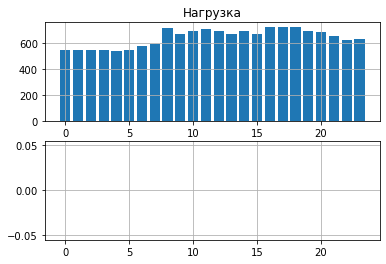

    'pyomo.core.base.set.OrderedSimpleSet'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.set.AbstractOrderedSimpleSet'>).
    This is usually indicative of a modelling error. To avoid this warning,
    use block.del_component() and block.add_component().
    'pyomo.core.base.set.OrderedSimpleSet'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.set.AbstractOrderedSimpleSet'>).
    This is usually indicative of a modelling error. To avoid this warning,
    use block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a model

    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
 

    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
 

    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'py

Cbc0010I After 4500 nodes, 1349 on tree, 231159 best solution, best possible 229262 (155.40 seconds)
Cbc0010I After 4600 nodes, 1385 on tree, 231159 best solution, best possible 229269 (156.59 seconds)
Cbc0010I After 4700 nodes, 1415 on tree, 231159 best solution, best possible 229271 (157.74 seconds)
Cbc0010I After 4800 nodes, 1448 on tree, 231159 best solution, best possible 229271 (158.87 seconds)
Cbc0010I After 4900 nodes, 1482 on tree, 231159 best solution, best possible 229277 (160.44 seconds)
Cbc0010I After 5000 nodes, 1512 on tree, 231159 best solution, best possible 229277 (161.54 seconds)
Cbc0010I After 5100 nodes, 1542 on tree, 231159 best solution, best possible 229280 (162.65 seconds)
Cbc0010I After 5200 nodes, 1576 on tree, 231159 best solution, best possible 229281 (164.19 seconds)
Cbc0010I After 5300 nodes, 1607 on tree, 231159 best solution, best possible 229281 (165.70 seconds)
Cbc0010I After 5400 nodes, 1637 on tree, 231159 best solution, best possible 229285 (166.82

Cbc0010I After 13300 nodes, 4065 on tree, 231157 best solution, best possible 229356 (283.17 seconds)
Cbc0010I After 13400 nodes, 4091 on tree, 231157 best solution, best possible 229356 (284.39 seconds)
Cbc0010I After 13500 nodes, 4119 on tree, 231157 best solution, best possible 229357 (285.51 seconds)
Cbc0010I After 13600 nodes, 4151 on tree, 231157 best solution, best possible 229358 (287.05 seconds)
Cbc0010I After 13700 nodes, 4175 on tree, 231157 best solution, best possible 229358 (288.16 seconds)
Cbc0010I After 13800 nodes, 4208 on tree, 231157 best solution, best possible 229359 (289.36 seconds)
Cbc0010I After 13900 nodes, 4245 on tree, 231157 best solution, best possible 229359 (290.55 seconds)
Cbc0010I After 14000 nodes, 4278 on tree, 231157 best solution, best possible 229359 (291.78 seconds)
Cbc0010I After 14100 nodes, 4302 on tree, 231157 best solution, best possible 229360 (292.87 seconds)
Cbc0010I After 14200 nodes, 4329 on tree, 231157 best solution, best possible 2293

Cbc0010I After 21400 nodes, 6439 on tree, 231102 best solution, best possible 229396 (386.87 seconds)
Cbc0010I After 21500 nodes, 6460 on tree, 231102 best solution, best possible 229397 (388.33 seconds)
Cbc0010I After 21600 nodes, 6491 on tree, 231102 best solution, best possible 229397 (389.48 seconds)
Cbc0010I After 21700 nodes, 6521 on tree, 231102 best solution, best possible 229397 (391.09 seconds)
Cbc0010I After 21800 nodes, 6544 on tree, 231102 best solution, best possible 229398 (392.20 seconds)
Cbc0010I After 21900 nodes, 6569 on tree, 231102 best solution, best possible 229399 (393.34 seconds)
Cbc0010I After 22000 nodes, 6596 on tree, 231102 best solution, best possible 229399 (394.51 seconds)
Cbc0010I After 22100 nodes, 6622 on tree, 231102 best solution, best possible 229400 (395.68 seconds)
Cbc0010I After 22200 nodes, 6647 on tree, 231102 best solution, best possible 229400 (396.77 seconds)
Cbc0010I After 22300 nodes, 6676 on tree, 231102 best solution, best possible 2294

Cbc0010I After 29500 nodes, 8699 on tree, 231102 best solution, best possible 229428 (485.28 seconds)
Cbc0010I After 29600 nodes, 8728 on tree, 231102 best solution, best possible 229428 (486.50 seconds)
Cbc0010I After 29700 nodes, 8757 on tree, 231102 best solution, best possible 229429 (487.71 seconds)
Cbc0010I After 29800 nodes, 8786 on tree, 231102 best solution, best possible 229429 (488.80 seconds)
Cbc0010I After 29900 nodes, 8819 on tree, 231102 best solution, best possible 229429 (490.03 seconds)
Cbc0010I After 30000 nodes, 8851 on tree, 231102 best solution, best possible 229430 (491.24 seconds)
Cbc0010I After 30100 nodes, 8881 on tree, 231102 best solution, best possible 229430 (492.43 seconds)
Cbc0010I After 30200 nodes, 8912 on tree, 231102 best solution, best possible 229431 (493.60 seconds)
Cbc0010I After 30300 nodes, 8942 on tree, 231102 best solution, best possible 229431 (494.80 seconds)
Cbc0010I After 30400 nodes, 8969 on tree, 231102 best solution, best possible 2294

Cbc0010I After 37300 nodes, 10885 on tree, 231102 best solution, best possible 229457 (583.36 seconds)
Cbc0020I Exiting on maximum time
Cbc0005I Partial search - best objective 231102 (best possible 229457), took 1389689 iterations and 37385 nodes (584.54 seconds)
Cbc0035I Maximum depth 71, 14778 variables fixed on reduced cost
 Couenne convexifier cuts was tried 45605 times and created 6227349 cuts of which 39136 were active after adding rounds of cuts
 ************************************************************
   (no optimal value found within tolerances).
   Optimization was not stopped because option
 "nlp_failure_behavior" has been set to fathom but
  beware that reported solution may not be optimal
 ************************************************************

 	"Not finished"
    model.name="unknown";
      - termination condition: maxIterations
      - message from solver: couenne\x3a Optimization interupted on limit.
# =======================================================

In [341]:
# demand
T1 = 0 #1700, 3700, 3865, 1875, 3605
T2 = 24 #1724, 3724, 3915, 1920, 3650

T = np.array([t for t in range(T1, T2)])

fig, ax = plt.subplots(2,1)
ax[0].bar(Load[T].index, Load[T])
ax[0].set_xlabel('Временной период')
ax[0].set_title('Нагрузка')
ax[1].bar(PV[T].index, PV[T])
ax[0].set_xlabel('Временной период')
ax[0].set_title('Нагрузка')
plt.show()

output = []

d1_up_before = 0
d2_up_before = 0
d3_up_before = 1
d4_up_before = 1

d1_down_before = 3
d2_down_before = 3
d3_down_before = 2
d4_down_before = 2

u1_start = 0
u2_start = 0
u3_start = 1
u4_start = 1

d1_availability_state = 1
d2_availability_state = 1
d3_availability_state = 1
d4_availability_state = 1

d1_min_up_time = 3
d2_min_up_time = 3 
d3_min_up_time = 3 
d4_min_up_time = 3

d1_min_down_time = 3
d2_min_down_time = 3 
d3_min_down_time = 3 
d4_min_down_time = 3 

ess1_availability_state = 1
ess2_availability_state = 1

soc1_before = 30
soc2_before = 30

m = unit_commitment()

pyo.SolverFactory('couenne').solve(m, logfile='FILENAME.log', tee=True).write()
#pyo.SolverFactory('mindtpy').solve(m, mip_solver='cbc', nlp_solver='ipopt', tee=True).write()

# Extract model output in list
Date = list(Load[T].index)
output.append([Date, m.x1.get_values().values(), m.x2.get_values().values(), 
                m.x3.get_values().values(), m.x4.get_values().values(), m.bat1_dch.get_values().values(),
              m.bat1_ch.get_values().values()]) 
                #m.bat1_dch.get_values().values(), m.bat1_ch.get_values().values(), ])


dfout = pd.DataFrame()
#dfout.index=Load[T].index
dfout['Load'] = Load[T1:T2]
dfout['d1'] = m.x1.get_values().values()
dfout['d2'] = m.x2.get_values().values()
dfout['d3'] = m.x3.get_values().values()
dfout['d4'] = m.x4.get_values().values()
# dfout['d1_suc'] = m.suc1.get_values().values()
# dfout['d2_suc'] = m.suc2.get_values().values()
# dfout['d3_suc'] = m.suc3.get_values().values()
# dfout['d4_suc'] = m.suc4.get_values().values()
# dfout['d1_sdc'] = m.sdc1.get_values().values()
# dfout['d2_sdc'] = m.sdc2.get_values().values()
# dfout['d3_sdc'] = m.sdc3.get_values().values()
# dfout['d4_sdc'] = m.sdc4.get_values().values()
dfout['bat1_dch'] = m.bat1_dch.get_values().values()
dfout['bat1_ch'] = m.bat1_ch.get_values().values()
dfout['bat2_dch'] = m.bat2_dch.get_values().values()
dfout['bat2_ch'] = m.bat2_ch.get_values().values()
dfout['soc1'] = m.soc1.get_values().values()
dfout['soc2'] = m.soc2.get_values().values()
dfout['pv1'] = m.PV1.get_values().values()
dfout['pv2'] = m.PV2.get_values().values()
dfout['pv3'] = m.PV3.get_values().values()
dfout['pv4'] = m.PV4.get_values().values()
dfout['pv5'] = m.PV5.get_values().values()
dfout['pv6'] = m.PV6.get_values().values()
dfout['pv7'] = m.PV7.get_values().values()
dfout['bat1_ch'] = -dfout['bat1_ch']
dfout['bat2_ch'] = -dfout['bat2_ch']
#dfout['dd1'] = m.u1.get_values().values()

dfout.index = Load[T1:T2].index
dfout['Load'] = Load[T1:T2]



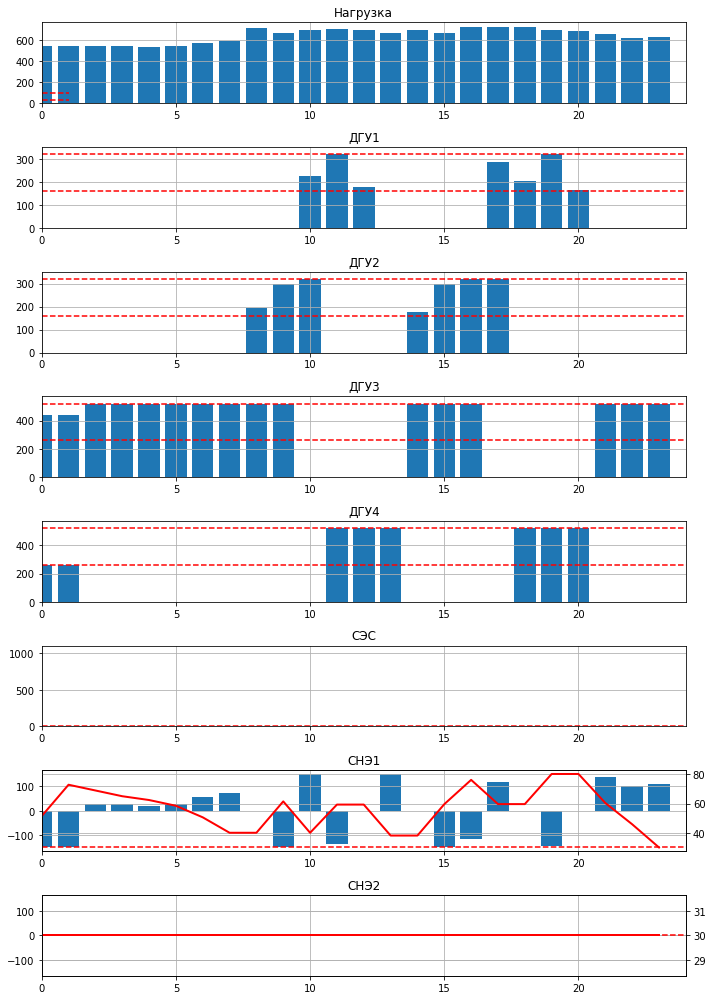

In [342]:
plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(8, 1, figsize=(10, 14))

ax[0].bar(T, [Load[t] for t in T])
ax[0].set_xlim(T1, T2)
ax[0].set_ylim(0, 1.1*700)
ax[0].plot(ax[1].get_xlim(), np.array([100, 100]), 'r--')
ax[0].plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[0].set_title('Нагрузка')

ax[1].bar(T, [m.x1[t]() for t in T])
ax[1].set_xlim(T1, T2)
ax[1].set_ylim(0, 1.1*DGU1_pmax)
ax[1].plot(ax[0].get_xlim(), np.array([DGU1_pmax, DGU1_pmax]), 'r--')
ax[1].plot(ax[0].get_xlim(), np.array([DGU1_pmin, DGU1_pmin]), 'r--')
ax[1].set_title('ДГУ1')

ax[2].bar(T, [m.x2[t]() for t in T])
ax[2].set_xlim(T1, T2)
ax[2].set_ylim(0, 1.1*DGU2_pmax)
ax[2].plot(ax[1].get_xlim(), np.array([DGU2_pmax, DGU2_pmax]), 'r--')
ax[2].plot(ax[1].get_xlim(), np.array([DGU2_pmin, DGU2_pmin]), 'r--')
ax[2].set_title('ДГУ2')

ax[3].bar(T, [m.x3[t]() for t in T])
ax[3].set_xlim(T1, T2)
ax[3].set_ylim(0, 1.1*DGU3_pmax)
ax[3].plot(ax[1].get_xlim(), np.array([DGU3_pmax, DGU3_pmax]), 'r--')
ax[3].plot(ax[1].get_xlim(), np.array([DGU3_pmin, DGU3_pmin]), 'r--')
ax[3].set_title('ДГУ3')

ax[4].bar(T, [m.x4[t]() for t in T])
ax[4].set_xlim(T1, T2)
ax[4].set_ylim(0, 1.1*DGU4_pmax)
ax[4].plot(ax[1].get_xlim(), np.array([DGU4_pmax, DGU4_pmax]), 'r--')
ax[4].plot(ax[1].get_xlim(), np.array([DGU4_pmin, DGU4_pmin]), 'r--')
ax[4].set_title('ДГУ4')

ax[5].bar(T, [m.pv1[t]()+ m.pv2[t]()+m.pv3[t]()+m.pv4[t]()+m.pv5[t]()+m.pv6[t]()+m.pv7[t]() for t in T])
ax[5].set_xlim(T1, T2)
ax[5].set_ylim(0, 1.1*1000)
ax[5].bar(T, [PV[t] for t in T], alpha=0.5)
ax[5].plot(ax[1].get_xlim(), np.array([0, 0]), 'r--')
ax[5].set_title('СЭС')

ax2 = ax[6].twinx()
ax2.plot(T, [m.soc1[t]() for t in T], color='red', linewidth=2)
ax[6].bar(T, [m.bat1_dch[t]()-m.bat1_ch[t]() for t in T])
ax[6].set_xlim(T1, T2)
ax[6].set_ylim(-1.1*150, 1.1*150)
#ax[6].plot(ax[1].get_xlim(), np.array([160, 160]), 'r--')
ax2.plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[6].set_title('СНЭ1')

ax3 = ax[7].twinx()
ax3.plot(T, [m.soc2[t]() for t in T], color='red', linewidth=2)
ax[7].bar(T, [m.bat2_dch[t]()-m.bat2_ch[t]() for t in T])
ax[7].set_xlim(T1, T2)
ax[7].set_ylim(-1.1*150, 1.1*150)
#ax[7].plot(ax[1].get_xlim(), np.array([160, 160]), 'r--')
ax3.plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[7].set_title('СНЭ2')



fig.tight_layout()
#dfout.plot(kind='bar')m = pyo.ConcreteModel()

#m.constraint.pprint()

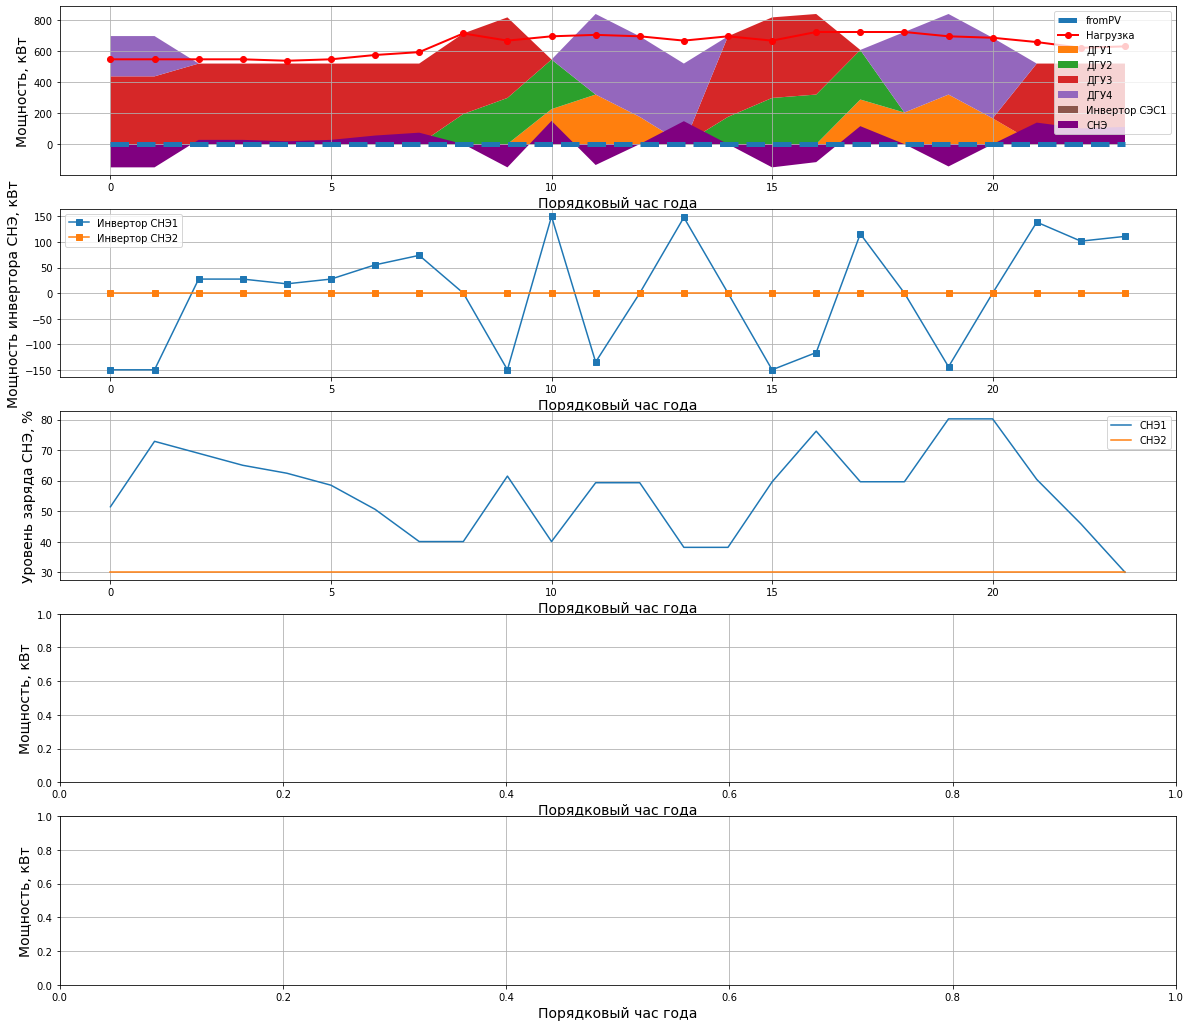

In [343]:
#графики

t1 = 0
t2 = 48

fig, ax = plt.subplots(5, figsize=(20, 18))
#(dfout*1000)[t1:t2].plot(ax=ax[0],marker='^')
ax[0].plot((Load[T1:T2]).index[t1:t2], PV[T1:T2][t1:t2], '--',label='fromPV', linewidth=5)
ax[2].plot((Load[T1:T2]).index[t1:t2], dfout['soc1'][t1:t2], label='СНЭ1')
ax[2].plot((Load[T1:T2]).index[t1:t2], dfout['soc2'][t1:t2], label='СНЭ2')
#ax[3].plot((Load[T1:T2]).index[t1:t2], Load[T1:T2][t1:t2], label='Load', marker='o')
ax[1].plot((Load[T1:T2]).index[t1:t2], (dfout['bat1_dch']+dfout['bat1_ch'])[t1:t2], label='Инвертор СНЭ1', marker='s')
ax[1].plot((Load[T1:T2]).index[t1:t2], (dfout['bat2_dch']+dfout['bat2_ch'])[t1:t2], label='Инвертор СНЭ2', marker='s')

ax[0].set_xlabel('Порядковый час года', fontsize=14)
ax[0].set_ylabel('Мощность, кВт', fontsize=14)
#ax[1].plot(nu.stores_t.p.index[t1:t2], (nu.stores_t.p*1000)[t1:t2], label = 'Storage')
ax[1].set_xlabel('Порядковый час года', fontsize=14)
ax[1].set_ylabel('Мощность инвертора СНЭ, кВт', fontsize=14)
ax[2].set_xlabel('Порядковый час года', fontsize=14)
ax[2].set_ylabel('Уровень заряда СНЭ, %', fontsize=14)

ax[3].set_xlabel('Порядковый час года', fontsize=14)
ax[3].set_ylabel('Мощность, кВт', fontsize=14)
#ax[1].plot(nu.stores_t.p.index[t1:t2], (nu.stores_t.p*1000)[t1:t2], label = 'Storage')
ax[4].set_xlabel('Порядковый час года', fontsize=14)
ax[4].set_ylabel('Мощность, кВт', fontsize=14)


#ax[1].plot(poa.index, tmy['ghi'], label = 'GHI')
ax[1].legend(loc='best')
ax[0].legend(loc='best')



ax[0].plot((Load[T1:T2]).index[t1:t2], Load[T1:T2][t1:t2], label='Нагрузка', marker='o', color='red', linewidth=2)

labels = ["ДГУ1", "ДГУ2", "ДГУ3", "ДГУ4", "Инвертор СЭС1", "Инвертор СЭС2", "Инвертор СЭС3", "Инвертор СЭС4",
         "Инвертор СЭС5", "Инвертор СЭС6", "Инвертор СЭС7"]

ax[0].stackplot((Load[T1:T2]).index[t1:t2], (dfout['d1'])[t1:t2],
                (dfout['d2'])[t1:t2],(dfout['d3'])[t1:t2],
                (dfout['d4'])[t1:t2],
                (dfout['pv1']+dfout['pv2']+dfout['pv3']+dfout['pv4']+dfout['pv5']+dfout['pv6']+dfout['pv7'])[t1:t2],
               baseline ='zero', labels=labels) #labels=labels
ax[0].stackplot((Load[T1:T2]).index[t1:t2], (dfout['bat1_dch']+dfout['bat2_dch'])[t1:t2]+(dfout['bat1_ch']+dfout['bat2_ch'])[t1:t2],
               baseline ='zero', colors = ['purple'],labels=['СНЭ'])

# ax[0].stackplot((Load[T1:T2]).index[t1:t2], (dfout['bat1_ch'])[t1:t2],
#                baseline ='zero', colors = ['purple'],labels=['СНЭ1 заряд'])
# ax[0].stackplot((Load[T1:T2]).index[t1:t2], (nu.stores_t.p['Battery Storage 2']*1000)[t1:t2],
#                baseline ='zero', colors =['brown'], labels=['СНЭ2'])


#colors =['orange', 'blue', 'green']




# ax[3].bar((Load[T1:T2]).index[t1:t2], 952*(poa_global/poa_global.max())[T1:T2][t1:t2], 
#           label='Прогнозная мощность\nвсего массива ФЭМ', alpha=0.5, edgecolor = "black")
# ax[3].plot((Load[T1:T2]).index[t1:t2], Load[T1:T2][t1:t2], label='Нагрузка', marker='o', color='red', linewidth=2)
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar1']*1000)[t1:t2], label='Инвертор СЭС1', edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar2']*1000)[t1:t2], label='Инвертор СЭС2',
#          bottom=(dfout['solar1']*1000)[t1:t2], edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar3']*1000)[t1:t2], label='Инвертор СЭС3',
#          bottom=(dfout['solar1']*1000)[t1:t2]+(dfout['solar2']*1000)[t1:t2],
#          edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar4']*1000)[t1:t2], label='Инвертор СЭС4',
#          bottom=(dfout['solar1']*1000)[t1:t2]+(dfout['solar2']*1000)[t1:t2]+
#           (dfout['solar3']*1000)[t1:t2], edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar5']*1000)[t1:t2], label='Инвертор СЭС5',
#          bottom=(dfout['solar1']*1000)[t1:t2]+(dfout['solar2']*1000)[t1:t2]+
#           (dfout['solar3']*1000)[t1:t2]+(dfout['solar4']*1000)[t1:t2],
#          edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar6']*1000)[t1:t2], label='Инвертор СЭС6',
#          bottom=(dfout['solar1']*1000)[t1:t2]+(dfout['solar2']*1000)[t1:t2]+
#           (dfout['solar3']*1000)[t1:t2]+(dfout['solar4']*1000)[t1:t2]+
#           (dfout['solar5']*1000)[t1:t2], edgecolor = "black")
# ax[3].bar((Load[T1:T2]).index[t1:t2],(dfout['solar7']*1000)[t1:t2], label='Инвертор СЭС7',
#          bottom=(dfout['solar1']*1000)[t1:t2]+(dfout['solar2']*1000)[t1:t2]+
#           (dfout['solar3']*1000)[t1:t2]+(dfout['solar4']*1000)[t1:t2]+
#           (dfout['solar5']*1000)[t1:t2]+(dfout['solar6']*1000)[t1:t2],
#          edgecolor = "black")


# ax[4].plot((Load[T1:T2]).index[t1:t2], Load[T1:T2][t1:t2], label='Нагрузка', marker='o', color='red', linewidth=2)
# ax[4].bar((Load[T1:T2]).index[t1:t2],(dfout['d1']*1000)[t1:t2], label='ДГУ1', edgecolor = "black")
# ax[4].bar((Load[T1:T2]).index[t1:t2],(dfout['d2']*1000)[t1:t2], label='ДГУ2',
#          bottom=(dfout['d1']*1000)[t1:t2], edgecolor = "black")
# ax[4].bar((Load[T1:T2]).index[t1:t2],(dfout['d3']*1000)[t1:t2], label='ДГУ3', edgecolor = "black",
#          bottom=(dfout['d1']*1000)[t1:t2]+(dfout['d2']*1000)[t1:t2])
# ax[4].bar((Load[T1:T2]).index[t1:t2],(dfout['d4']*1000)[t1:t2], label='ДГУ4',
#          bottom=(dfout['d1']*1000)[t1:t2]+(dfout['d2']*1000)[t1:t2]+
#           +(dfout['d3']*1000)[t1:t2],
#           edgecolor = "black")
# ax[4].bar((Load[T1:T2]).index[t1:t2],(nu.stores_t.p['Battery Storage 1']*1000)[t1:t2], label='СНЭ1',
#          edgecolor = "black", width=0.4)
# ax[4].bar((Load[T1:T2]).index[t1:t2],(nu.stores_t.p['Battery Storage 2']*1000)[t1:t2], label='СНЭ2',
#          bottom=(nu.stores_t.p['Battery Storage 1']*1000)[t1:t2],
#           edgecolor = "black", width=0.4)



# ax[0].grid()
# ax[1].grid()
# ax[2].grid()
# ax[3].grid()
# ax[4].grid()
ax[0].legend(loc='best')
ax[2].legend(loc='best')
# ax[3].legend(loc='best')
# ax[4].legend(loc='best')

plt.show()

In [344]:
dfout.style.background_gradient(cmap=cm)

,Load,d1,d2,d3,d4,bat1_dch,bat1_ch,bat2_dch,bat2_ch,soc1,soc2,pv1,pv2,pv3,pv4,pv5,pv6,pv7
0,547.455187,0.000000,0.000000,437.455187,260.000000,0.000000,-150.000000,0.000000,-0.000000,51.428571,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,547.455187,0.000000,0.000000,437.455187,260.000000,0.000000,-150.000000,0.000000,-0.000000,72.857143,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,547.455187,0.000000,0.000000,520.000000,0.000000,27.455187,-0.000000,0.000000,-0.000000,68.934973,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,547.455187,0.000000,0.000000,520.000000,0.000000,27.455187,-0.000000,0.000000,-0.000000,65.012804,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,538.176286,0.000000,0.000000,520.000000,0.000000,18.176286,-0.000000,0.000000,-0.000000,62.416191,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,547.455187,0.000000,0.000000,520.000000,0.000000,27.455187,-0.000000,0.000000,-0.000000,58.494022,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,575.291892,0.000000,0.000000,520.000000,0.000000,55.291892,-0.000000,0.000000,-0.000000,50.595180,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,593.849694,0.000000,0.000000,520.000000,0.000000,73.849694,-0.000000,0.000000,-0.000000,40.045224,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,714.475414,0.000000,194.475414,520.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,40.045224,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,668.080906,0.000000,298.080906,520.000000,0.000000,0.000000,-150.000000,0.000000,-0.000000,61.473795,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### MILP 

In [98]:
#PV = poa_global*0.2*5200/1000

Fuel_price = 45

# demand
T1 = 0 #1700, 3700
T2 = 48 #1724, 3724

T = np.array([t for t in range(T1, T2)])

# fig, ax = plt.subplots(2,1)
# ax[0].bar(Load[T].index, Load[T])
# ax[0].set_xlabel('Временной период')
# ax[0].set_title('Нагрузка')
# ax[1].bar(PV[T].index, PV[T])
# ax[0].set_xlabel('Временной период')
# ax[0].set_title('Нагрузка')
# plt.show()

m = pyo.ConcreteModel()

output = []

d1_up_before = 0
d2_up_before = 0
d3_up_before = 1
d4_up_before = 1

d1_down_before = 3
d2_down_before = 3
d3_down_before = 0
d4_down_before = 0

u1_start = 0
u2_start = 0
u3_start = 1
u4_start = 1

d1_availability_state = 1
d2_availability_state = 1
d3_availability_state = 1
d4_availability_state = 1

d1_min_up_time = 3
d2_min_up_time = 3 
d3_min_up_time = 3 
d4_min_up_time = 3

d1_min_down_time = 3
d2_min_down_time = 3 
d3_min_down_time = 3 
d4_min_down_time = 3 



soc1_before = 100
soc2_before = 100

def balance(model, i):
    return m.x1[i] + m.x2[i] + m.x3[i] + m.x4[i] + m.bat1_dch[i] - m.bat1_ch[i] + m.bat2_dch[i] - m.bat2_ch[i] + m.PV1[i] + m.PV2[i] + m.PV3[i] + m.PV4[i] + m.PV5[i] + m.PV6[i] + m.PV7[i] == (np.asarray(Load)[i]) # +  





def cnstr1(model, i):
    Lj = min(T2-T1, (d3_min_up_time-d3_up_before)*u3_start)
    lst = []
    for k in range (1, Lj+1):
        lst.append(1-m.u3[k])
        print(lst)
    return sum(lst) == 0


def cnstr3(model, i):
    Lj = min(T2-T1, (d3_min_up_time-d3_up_before)*u3_start)
    lst = []
    for k in range(Lj+T2-T1-d3_min_up_time+1, i+d3_min_up_time):
        lst.append(m.u3[k])
    return sum(lst) >= d3_min_up_time*m.u3[i]








def d1_min_up_time_c(model, i):
    if i == T1:
        return (d1_up_before - d1_min_up_time)*(u1_start - m.u1[i]) >= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u1[i-1])
        for j in range(T1, i):
            uj.append(m.u1[j])
        return ((sum(uj) - d1_min_up_time)*(m.u1[i-1] - m.u1[i])) >= 0
    else:
        return ((m.u1[i-1] + m.u1[i-2] + m.u1[i-3] - d1_min_up_time)*(m.u1[i-1] - m.u1[i])) >= 0
    
def d2_min_up_time_c(model, i):
    if i == T1:
        return (d2_up_before - d2_min_up_time)*(u2_start - m.u2[i]) >= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u2[i-1])
        for j in range(T1, i):
            uj.append(m.u2[j])
        return ((sum(uj) - d2_min_up_time)*(m.u2[i-1] - m.u2[i])) >= 0
    else:
        return ((m.u2[i-1] + m.u2[i-2] + m.u2[i-3] - d2_min_up_time)*(m.u2[i-1] - m.u2[i])) >= 0
    
def d3_min_up_time_c(model, i):
    if i == T1:
        return (d3_up_before - d3_min_up_time)*(u3_start - m.u3[i]) >= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u3[i-1])
        for j in range(T1, i):
            uj.append(m.u3[j])
        return ((sum(uj) - d3_min_up_time)*(m.u3[i-1] - m.u3[i])) >= 0
    else:
        return ((m.u3[i-1] + m.u3[i-2] + m.u3[i-3] - d3_min_up_time)*(m.u3[i-1] - m.u3[i])) >= 0

def d4_min_up_time_c(model, i):
    if i == T1:
        return (d4_up_before - d4_min_up_time)*(u4_start - m.u4[i]) >= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u4[i-1])
        for j in range(T1, i):
            uj.append(m.u4[j])
        return ((sum(uj) - d4_min_up_time)*(m.u4[i-1] - m.u4[i])) >= 0
    else:
        return ((m.u4[i-1] + m.u4[i-2] + m.u4[i-3] - d4_min_up_time)*(m.u4[i-1] - m.u4[i])) >= 0

def d1_min_down_time_c(model, i):
    if i == T1:
        return (d1_down_before + d1_min_down_time)*(-u1_start + m.u1[i]) <= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u1[i-1])
        for j in range(T1, i):
            uj.append(m.u1[j])
        return ((sum(uj) - 2 + d1_min_down_time)*(-m.u1[i-1] + m.u1[i])) <= 0
    else:
        return ((m.u1[i-1] + m.u1[i-2] + m.u1[i-3] - 3 + d1_min_down_time)*(-m.u1[i-1] + m.u1[i])) <= 0

def d2_min_down_time_c(model, i):
    if i == T1:
        return (d2_down_before + d2_min_down_time)*(-u2_start + m.u2[i]) <= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u2[i-1])
        for j in range(T1, i):
            uj.append(m.u2[j])
        return ((sum(uj) - 2 + d2_min_down_time)*(-m.u2[i-1] + m.u2[i])) <= 0
    else:
        return ((m.u2[i-1] + m.u2[i-2] + m.u2[i-3] - 3 + d2_min_down_time)*(-m.u2[i-1] + m.u2[i])) <= 0

def d3_min_down_time_c(model, i):
    if i == T1:
        return (d3_down_before + d3_min_down_time)*(-u3_start + m.u3[i]) <= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u3[i-1])
        for j in range(T1, i):
            uj.append(m.u3[j])
        return ((sum(uj) - 2 + d3_min_down_time)*(-m.u3[i-1] + m.u3[i])) <= 0
    else:
        return ((m.u3[i-1] + m.u3[i-2] + m.u3[i-3] - 3 + d3_min_down_time)*(-m.u3[i-1] + m.u3[i])) <= 0

def d4_min_down_time_c(model, i):
    if i == T1:
        return (d4_down_before + d4_min_down_time)*(-u4_start + m.u4[i]) <= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u4[i-1])
        for j in range(T1, i):
            uj.append(m.u4[j])
        return ((sum(uj) - 2 + d4_min_down_time)*(-m.u4[i-1] + m.u4[i])) <= 0
    else:
        return ((m.u4[i-1] + m.u4[i-2] + m.u4[i-3] - 3 + d4_min_down_time)*(-m.u4[i-1] + m.u4[i])) <= 0

#ограничение глубины разряда СНЭ  
def soc1_ctrl(model, i):
    if i == T1:
        return m.soc1[i] == soc1_before - 100*m.bat1_dch[i]/700 + 100*m.bat1_ch[i]/700
    else:
        return m.soc1[i] == m.soc1[i-1] - 100*m.bat1_dch[i]/700 + 100*m.bat1_ch[i]/700

def soc2_ctrl(model, i):
    if i == T1:
        return m.soc2[i] == soc2_before - 100*m.bat2_dch[i]/700 + 100*m.bat2_ch[i]/700
    else:
        return m.soc2[i] == m.soc2[i-1] - 100*m.bat2_dch[i]/700 + 100*m.bat2_ch[i]/700
    
#СНЭ не должна заряжаться и разряжаться одновременно     
def ch_x_dch1 (model, i):
    return m.bat1_ch[i] * m.bat1_dch[i] == 0

def ch_x_dch2 (model, i):
    return m.bat2_ch[i] * m.bat2_dch[i] == 0

def ch_x_dch3 (model, i):
    return m.x1[i] + m.x2[i] + m.x3[i] + m.x4[i] + m.bat1_dch[i] - m.bat1_ch[i] + m.bat2_dch[i] - m.bat2_ch[i] + m.PV1[i] + m.PV2[i] + m.PV3[i] + m.PV4[i] + m.PV5[i] + m.PV6[i] + m.PV7[i]

# def ch_x_dch4 (model, i):
#     return m.bat2_ch[i] - m.bat1_dch[i] == 0

#если СНЭ заряжена не на 100% не ограничиваем инверторы СЭС 
def curtailment_control1 (model, i):
    return m.pv1[i] - PV[i] - m.bat1_ch[i] <= 0 


def d1_availability (model, i):
    return m.u1[i] == m.u1[i] * d1_availability_state

def d2_availability (model, i):
    return m.u2[i] == m.u2[i] * d2_availability_state

def d3_availability (model, i):
    return m.u3[i] == m.u3[i] * d3_availability_state

def d4_availability (model, i):
    return m.u4[i] == m.u4[i] * d4_availability_state

def unit_commitment():
    
    m.N = pyo.Set(initialize=N)
    m.T = pyo.Set(initialize=T)

    m.x1 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, DGU1_pmax))
    m.u1 = pyo.Var(m.T, domain=pyo.Binary)
    
    m.x2 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, DGU2_pmax))
    m.u2 = pyo.Var(m.T, domain=pyo.Binary)
    
    m.x3 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, DGU3_pmax))
    m.u3 = pyo.Var(m.T, domain=pyo.Binary)
    
    m.x4 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, DGU4_pmax))
    m.u4 = pyo.Var(m.T, domain=pyo.Binary)
    
    m.bat1_dch = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, ESS_inv))
    m.bat1_ch = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, ESS_inv))
    
    m.bat2_dch = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, ESS_inv))
    m.bat2_ch = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, ESS_inv))
    
    m.soc1 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (30, 100))
    m.soc2 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (30, 100))
    
    m.PV1 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV2 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV3 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV4 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV5 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV6 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV7 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    
    #m.PV1_s = pyo.Var(m.T, domain=pyo.Binary)
    #m.PV2_s = pyo.Var(m.T, domain=pyo.Binary)
    
    
    # objective
    m.cost = pyo.Objective(expr = sum(m.x1[t]*0.3031*Fuel_price + m.x2[t]*0.3031*Fuel_price +
                                      m.x3[t]*0.2788*Fuel_price + m.x4[t]*0.2788*Fuel_price +
                                      m.bat1_dch[t]*12 + m.bat2_dch[t]*12 + m.bat1_ch[t]*14 + m.bat2_ch[t]*14  for t in m.T), sense=pyo.minimize)
    
    # demand
    m.demand = pyo.Constraint(m.T, rule=balance)
    
    # semi-continuous
    m.lb1 = pyo.Constraint(m.T, rule=lambda m, t: DGU1_pmin*m.u1[t] <= m.x1[t])
    m.ub1 = pyo.Constraint(m.T, rule=lambda m, t: DGU1_pmax*m.u1[t] >= m.x1[t])
    m.lb2 = pyo.Constraint(m.T, rule=lambda m, t: DGU2_pmin*m.u2[t] <= m.x2[t])
    m.ub2 = pyo.Constraint(m.T, rule=lambda m, t: DGU2_pmax*m.u2[t] >= m.x2[t])
    m.lb3 = pyo.Constraint(m.T, rule=lambda m, t: DGU3_pmin*m.u3[t] <= m.x3[t])
    m.ub3 = pyo.Constraint(m.T, rule=lambda m, t: DGU3_pmax*m.u3[t] >= m.x3[t])
    m.lb4 = pyo.Constraint(m.T, rule=lambda m, t: DGU4_pmin*m.u4[t] <= m.x4[t])
    m.ub4 = pyo.Constraint(m.T, rule=lambda m, t: DGU4_pmax*m.u4[t] >= m.x4[t])
    
    m.pv1 = pyo.Constraint(m.T, rule=lambda m, t: m.PV1[t] <= PV[t]/7)
    m.pv2 = pyo.Constraint(m.T, rule=lambda m, t: m.PV2[t] <= PV[t]/7)
    m.pv3 = pyo.Constraint(m.T, rule=lambda m, t: m.PV3[t] <= PV[t]/7)
    m.pv4 = pyo.Constraint(m.T, rule=lambda m, t: m.PV4[t] <= PV[t]/7)
    m.pv5 = pyo.Constraint(m.T, rule=lambda m, t: m.PV5[t] <= PV[t]/7)
    m.pv6 = pyo.Constraint(m.T, rule=lambda m, t: m.PV6[t] <= PV[t]/7)
    m.pv7 = pyo.Constraint(m.T, rule=lambda m, t: m.PV7[t] <= PV[t]/7)
    
#     m.pv1_curtailment = pyo.Constraint(m.T, rule=lambda m, t: m.PV1[t] <= m.bat1_ch[t])
#     m.pv2_curtailment = pyo.Constraint(m.T, rule=lambda m, t: m.PV2[t] <= m.bat1_ch[t])
    
#     m.min_up_time_d1 = pyo.Constraint(m.T, rule=d1_min_up_time_c)
#     m.min_up_time_d2 = pyo.Constraint(m.T, rule=d2_min_up_time_c)
#     m.min_up_time_d3 = pyo.Constraint(m.T, rule=d3_min_up_time_c)
#     m.min_up_time_d4 = pyo.Constraint(m.T, rule=d4_min_up_time_c)
    
#     m.min_down_time_d1 = pyo.Constraint(m.T, rule=d1_min_down_time_c)
#     m.min_down_time_d2 = pyo.Constraint(m.T, rule=d2_min_down_time_c)
#     m.min_down_time_d3 = pyo.Constraint(m.T, rule=d3_min_down_time_c)
#     m.min_down_time_d4 = pyo.Constraint(m.T, rule=d4_min_down_time_c)
    
    m.d1_ava = pyo.Constraint(m.T, rule=d1_availability)
    m.d2_ava = pyo.Constraint(m.T, rule=d2_availability)
    m.d3_ava = pyo.Constraint(m.T, rule=d3_availability)
    m.d4_ava = pyo.Constraint(m.T, rule=d4_availability)
    
    m.soc1_ctrl = pyo.Constraint(m.T, rule=soc1_ctrl)
    m.soc2_ctrl = pyo.Constraint(m.T, rule=soc2_ctrl)
#     m.chdch1 = pyo.Constraint(m.T, rule=ch_x_dch1)
#     m.chdch2 = pyo.Constraint(m.T, rule=ch_x_dch2)
#     m.chdch3 = pyo.Constraint(m.T, rule=ch_x_dch3)
#     m.chdch4 = pyo.Constraint(m.T, rule=ch_x_dch4)
    #m.d1_cstr1 = pyo.Constraint(m.T, rule=d1_cstr1)
    
    #m.curt1 = pyo.Constraint(m.T, rule=curtailment_control1) 
    
    m.cnstr1 = pyo.Constraint(m.T, rule=cnstr1)
    m.cnstr3 = pyo.Constraint(m.T, rule=cnstr3)
    
    return m

m = unit_commitment()

pyo.SolverFactory('cbc').solve(m, logfile='FILENAME.log', tee=True).write()

# Extract model output in list
Date = list(Load[T].index)
output.append([Date, m.x1.get_values().values(), m.x2.get_values().values(), 
                m.x3.get_values().values(), m.x4.get_values().values(), m.bat1_dch.get_values().values(),
              m.bat1_ch.get_values().values()]) 
                #m.bat1_dch.get_values().values(), m.bat1_ch.get_values().values(), ])


dfout = pd.DataFrame()
#dfout.index=Load[T].index
#dfout.index = Load[T1:T2].index
dfout['Load'] = Load[T1:T2]
dfout['d1'] = m.x1.get_values().values()
dfout['d2'] = m.x2.get_values().values()
dfout['d3'] = m.x3.get_values().values()
dfout['d4'] = m.x4.get_values().values()
dfout['bat1_dch'] = m.bat1_dch.get_values().values()
dfout['bat1_ch'] = m.bat1_ch.get_values().values()
dfout['bat2_dch'] = m.bat2_dch.get_values().values()
dfout['bat2_ch'] = m.bat2_ch.get_values().values()
dfout['soc1'] = m.soc1.get_values().values()
dfout['soc2'] = m.soc2.get_values().values()
dfout['pv1'] = m.PV1.get_values().values()
dfout['pv2'] = m.PV2.get_values().values()
dfout['pv3'] = m.PV3.get_values().values()
dfout['pv4'] = m.PV4.get_values().values()
dfout['pv5'] = m.PV5.get_values().values()
dfout['pv6'] = m.PV6.get_values().values()
dfout['pv7'] = m.PV7.get_values().values()
dfout['bat1_ch'] = -dfout['bat1_ch']
dfout['bat2_ch'] = -dfout['bat2_ch']
#dfout['dd1'] = m.u1.get_values().values()




[<pyomo.core.expr.numeric_expr.SumExpression object at 0x000000003028C740>, <pyomo.core.expr.numeric_expr.SumExpression object at 0x000000003028C1C0>]
[<pyomo.core.expr.numeric_expr.SumExpression object at 0x000000003028C740>, <pyomo.core.expr.numeric_expr.SumExpression object at 0x000000003028C1C0>]
[<pyomo.core.expr.numeric_expr.SumExpression object at 0x000000003028C740>, <pyomo.core.expr.numeric_expr.SumExpression object at 0x000000003028C9C0>]
[<pyomo.core.expr.numeric_expr.SumExpression object at 0x000000003028C740>, <pyomo.core.expr.numeric_expr.SumExpression object at 0x000000002FF1D700>]
[<pyomo.core.expr.numeric_expr.SumExpression object at 0x000000003028C740>, <pyomo.core.expr.numeric_expr.SumExpression object at 0x000000002FF1D0C0>]
[<pyomo.core.expr.numeric_expr.SumExpression object at 0x000000003028C740>, <pyomo.core.expr.numeric_expr.SumExpression object at 0x000000002FF1D4C0>]
[<pyomo.core.expr.numeric_expr.SumExpression object at 0x000000003028C740>, <pyomo.core.expr.n

ERROR: Constructing component 'cnstr3' from data=None failed: KeyError: "Index
    '48' is not valid for indexed component 'u3'"


KeyError: "Index '48' is not valid for indexed component 'u3'"

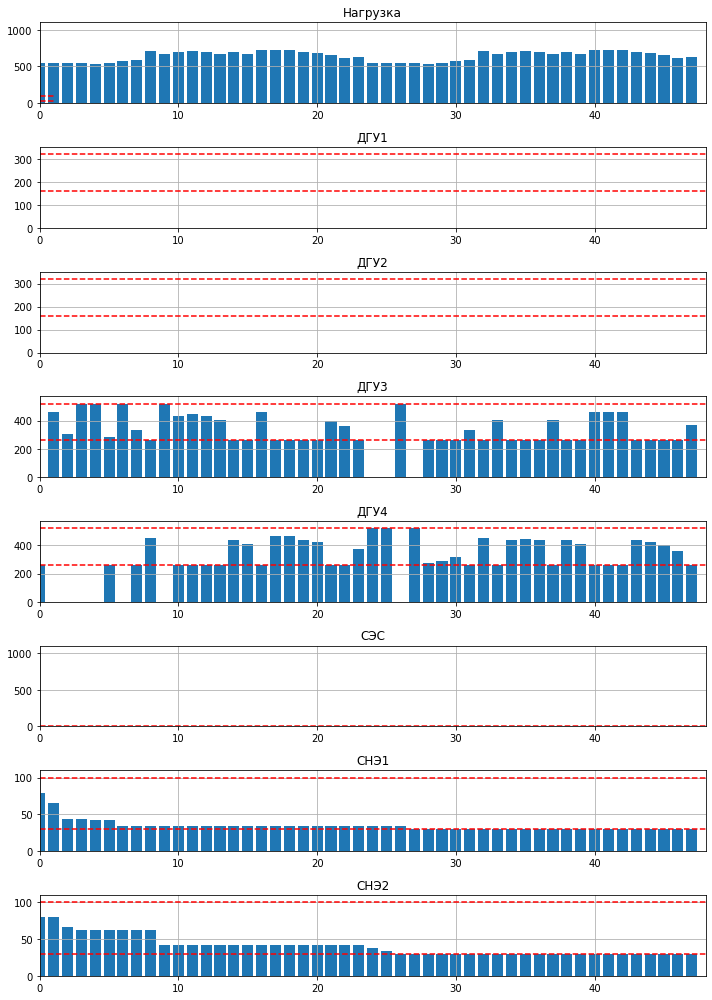

In [97]:
plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(8, 1, figsize=(10, 14))

ax[0].bar(T, [Load[t] for t in T])
ax[0].set_xlim(T1, T2)
ax[0].set_ylim(0, 1.1*1000)
ax[0].plot(ax[1].get_xlim(), np.array([100, 100]), 'r--')
ax[0].plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[0].set_title('Нагрузка')

ax[1].bar(T, [m.x1[t]() for t in T])
ax[1].set_xlim(T1, T2)
ax[1].set_ylim(0, 1.1*DGU1_pmax)
ax[1].plot(ax[0].get_xlim(), np.array([DGU1_pmax, DGU1_pmax]), 'r--')
ax[1].plot(ax[0].get_xlim(), np.array([DGU1_pmin, DGU1_pmin]), 'r--')
ax[1].set_title('ДГУ1')

ax[2].bar(T, [m.x2[t]() for t in T])
ax[2].set_xlim(T1, T2)
ax[2].set_ylim(0, 1.1*DGU2_pmax)
ax[2].plot(ax[1].get_xlim(), np.array([DGU2_pmax, DGU2_pmax]), 'r--')
ax[2].plot(ax[1].get_xlim(), np.array([DGU2_pmin, DGU2_pmin]), 'r--')
ax[2].set_title('ДГУ2')

ax[3].bar(T, [m.x3[t]() for t in T])
ax[3].set_xlim(T1, T2)
ax[3].set_ylim(0, 1.1*DGU3_pmax)
ax[3].plot(ax[1].get_xlim(), np.array([DGU3_pmax, DGU3_pmax]), 'r--')
ax[3].plot(ax[1].get_xlim(), np.array([DGU3_pmin, DGU3_pmin]), 'r--')
ax[3].set_title('ДГУ3')

ax[4].bar(T, [m.x4[t]() for t in T])
ax[4].set_xlim(T1, T2)
ax[4].set_ylim(0, 1.1*DGU4_pmax)
ax[4].plot(ax[1].get_xlim(), np.array([DGU4_pmax, DGU4_pmax]), 'r--')
ax[4].plot(ax[1].get_xlim(), np.array([DGU4_pmin, DGU4_pmin]), 'r--')
ax[4].set_title('ДГУ4')

ax[5].bar(T, [m.pv1[t]()+ m.pv2[t]()+m.pv3[t]()+m.pv4[t]()+m.pv5[t]()+m.pv6[t]()+m.pv7[t]() for t in T])
ax[5].set_xlim(T1, T2)
ax[5].set_ylim(0, 1.1*1000)
ax[5].bar(T, [PV[t] for t in T], alpha=0.5)
ax[5].plot(ax[1].get_xlim(), np.array([0, 0]), 'r--')
ax[5].set_title('СЭС')

ax[6].bar(T, [m.soc1[t]() for t in T])
ax[6].set_xlim(T1, T2)
ax[6].set_ylim(0, 1.1*100)
ax[6].plot(ax[1].get_xlim(), np.array([100, 100]), 'r--')
ax[6].plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[6].set_title('СНЭ1')

ax[7].bar(T, [m.soc2[t]() for t in T])
ax[7].set_xlim(T1, T2)
ax[7].set_ylim(0, 1.1*100)
ax[7].plot(ax[1].get_xlim(), np.array([100, 100]), 'r--')
ax[7].plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[7].set_title('СНЭ2')



fig.tight_layout()
#dfout.plot(kind='bar')m = pyo.ConcreteModel()

#m.constraint.pprint()